In [6]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method 
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.torch.attacks.noise import noise 
from cleverhans.torch.attacks.hop_skip_jump_attack import hop_skip_jump_attack 
from cleverhans.torch.attacks.spsa import spsa 
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2 
from cleverhans.torch.attacks.sparse_l1_descent import sparse_l1_descent 

import random



In [7]:
#https://github.com/nhamlv-55/CFI_NNs/blob/master/MNIST_toy/Experiment-Feb28-xujie-Copy1.ipynb

from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier, NewTinyCNN
import regularizer_losts as rl
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
import utils as CFI_utils
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
#from frozendict import frozendict
from datetime import datetime
# import seaborn as sn
import pandas as pd


from absl import app, flags
from easydict import EasyDict
import torch.nn as nn





%matplotlib inline

import seaborn as sns
colors = sns.color_palette("tab10")

#Logging stuffs
import logging
import sys
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]

#configs
epochs = 10
batch_size = 1000
test_batch_size = 10000
stable_batch_size = 60000
# use_cuda = torch.cuda.is_available()
use_cuda = False
print(use_cuda)

lr = 0.01
log_interval = 100

#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")
print(device)

train_kwargs = {'batch_size': batch_size}

test_kwargs = {'batch_size': test_batch_size}
stable_kwargs = {'batch_size': stable_batch_size}
unshuffle_kwargs = {'batch_size': test_batch_size}
unshuffle_train_kwargs = {'batch_size': stable_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    stable_kwargs.update(cuda_kwargs)
    unshuffle_kwargs.update(cuda_kwargs)
    unshuffle_kwargs['shuffle'] = False
    unshuffle_train_kwargs.update(cuda_kwargs)
    unshuffle_train_kwargs['shuffle'] = False
class Shift:
    def __init__(self, shift = 0):
        print("alive")
        self.shift = shift

    def __call__(self, arr):
        print("running")
        #print(arr)
        return arr
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"
    
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
   
  
])

def shift_and_roll(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:
    return torch.roll(arr, shifts = (x,y), dims = (0,1)) #indexing
def shift(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:

    pad = [0,0,0,0]
    x_start = 0
    x_end = 0
    y_start = 0
    y_end = 0
    if x >= 0:
        pad[0] = x
        x_start = 0
        x_end = 28
    else:
        pad[1] = abs(x)
        x_start = -28
         
         
        
         
    
    if y >= 0:
        pad[2] = y
        y_start = 0
        y_end = 28
    else:
        pad[3] = abs(y)
        y_start= -28
        print("ys is {}".format(y_start))
    

    padder = torch.nn.ZeroPad2d(tuple(pad))
  
    result = padder(arr)

    if y < 0:
        y_end = result.shape[0]
    if x < 0:
        x_end = result.shape[1]
    
    return result[y_start:y_end, x_start:x_end]

def noisify(arr : torch.Tensor , distribution : torch.distributions.Distribution) -> torch.Tensor: #randomly add noise
   
    #print(distribution.sample(arr.size()).shape\\)
    #print(torch.reshape(distribution.sample(arr.size()), (28,28)).shape)
   
    noise = torch.reshape(distribution.sample(arr.size()), (arr.shape))
    return arr + noise
transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
])


False
cpu


In [8]:
def transform_dataset(dataset):
    '''
    DO A STATE CHANGE
    '''
    shift_x = 1
    shift_y = 0
    mu = 1
    sigma = 1
    do_shift = False
    do_noisfy = True
    modification_string = "base"
    if do_shift:
        modification_string += " -shift {} {} - ".format(shift_x, shift_y)
    if do_noisfy:
        modification_string += " -noise added using gaussian using mean {} and stddev {}- ".format(mu, sigma)
    for i in range(dataset.data.shape[0]):
        if do_shift:
            dataset.data[i,:,:] = shift(dataset.data[i,:,:],shift_x, shift_y)
        
        if do_noisfy:
            gaussian = torch.distributions.Normal(loc = mu, scale = sigma)# loc = mu, scale = stddev

            dataset.data[i,:,:] = noisify(dataset.data[i,:,:], gaussian)
    return modification_string

## Train/Load model


In [9]:
def check_gradient(grad, label, last_sorted_grads, plot = False):
    logging.info("CHECKING GRADIENT FOR LABEL {}".format(label))
    sum_abs_grad = np.sum(abs(grad[label]), axis = 0)
    
    current_sorted_grad = (-sum_abs_grad).argsort()
    
#     if len(last_sorted_grads[label]) > 0:
#         for k in [100, 200, 300, 400]:
#             prev_top_k = set(last_sorted_grads[label][-1][:k])
#             current_top_k = set(current_sorted_grad[:k])
#             intersect = prev_top_k.intersection(current_top_k)
#             logging.info('k = {}. How many top Gradients are stable since last epoch?: {}'.format(k, len(intersect)))
        
    for k in [0, 9, 99, 199]:    
        logging.debug('{}th biggest gradient = {}'.format(k, np.sort(-sum_abs_grad)[k]))
    if plot:
        fig = plt.figure(figsize=(30, 1))
        plt.bar(range(sum_abs_grad.shape[0]), sum_abs_grad)
        plt.show()
        print(sum_abs_grad.max(), sum_abs_grad.argmax(), sum_abs_grad.min())

    return current_sorted_grad



#init stuffs
LOAD = True
# LOADPATH = 'FFN19-17-24'
LOADPATH = 'FFN18_28_21'
# LOADPATH = 'TinyCNN14-28-29'

LAST_N_EPOCHS = 10

dataset1 = datasets.MNIST('./data', train=True, download=False,
                          transform=transform)
dataset2 = datasets.MNIST('./data', train=False, download=False,
                          transform=transform)


#transform_dataset(dataset1)
#modification_string = transform_dataset(dataset2)
modification_string = ""
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
unshuffle_train_loader = torch.utils.data.DataLoader(dataset1, **unshuffle_train_kwargs)

unshuffle_test_loader = torch.utils.data.DataLoader(dataset2, **unshuffle_kwargs)

model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
# model = TinyCNN().to(device)

if LOAD:
    model.load_state_dict(torch.load(LOADPATH, map_location=device))
else:

    epochs = 10
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)
    last_sorted_grads = defaultdict(list)
    
    all_rows = []
    
    for epoch in tqdm(range(1, epochs + 1)):
        model.register_gradient()
        model.train()
        target_log  = None # need to record the label to match with the gradient later
        for data, target in train_loader:
            target_log = np.concatenate((target_log, target), axis = 0) if target_log is not None else target
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.float())
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        CFI_utils.test(model, device, test_loader)
#         scheduler.step()
        grad = CFI_utils.get_grad_each_label(model.gradient_log, 
                                      target_log = target_log, 
                                      layers = ['fc1', 'fc2', 'fc3', 'fc4'], 
#                                       layers = ['conv1', 'conv2','fc1', 'fc2'],
                                      labels = range(10))
        torch.save(model.state_dict(), model.model_savename())
        
        row_data = []
        for label in range(10):
            r = []
            logging.info("After {} epoch:".format(epoch))
            last_sorted_grads[label].append(check_gradient(grad, label, last_sorted_grads))
            
            
            if epoch >= LAST_N_EPOCHS:
                for k in [100, 200, 300, 400]:
                    all_top_k = [set(sorted_grad[:k]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
                    intersect = set.intersection(*all_top_k)
                    logging.info('k = {}. How many top Gradients are stable among all last {} epochs?: {}'.format(k, LAST_N_EPOCHS, len(intersect)))

                    

with torch.no_grad():
    total = 0
    correct = 0
    for data, target in dataset2:
        data_extend = data[None, :]
        if int(torch.argmax(model.cpu()(data.cpu()), dim = 1)) == target:
#         if int(torch.argmax(model.cuda()(data_extend.cuda()), dim = 1)) == target:
            correct += 1
        total+=1
    "accuracy {}".format( correct/total)
    modification_string += " -accuracy {}-".format( correct/total)
    print(modification_string)

model = model.to(device)

 -accuracy 0.9042-


#### Compute all patterns in the training set, and put them into corresponding labels

In [10]:
class Patterns:
    def __init__(self, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, labels, layers):
        self._model = model
        self.label2patterns = {}
        self.label2idx = {}
        self._labels = labels
        self._layers = layers
        self._dataloader = dataloader
        self._populate()
        
    def _populate(self):
        
        label2patterns = {}
        label2idx = {}
        for label in self._labels:
            patterns = []
            filter_ids = []
            
            for data, target in self._dataloader:
                
                flter = np.where(target == label)
                filter_ids.append(flter)
                data = data[flter]
                logging.debug(data.shape[0])
                pattern = self._model.get_pattern(data, layers, device, flatten = True)
                logging.debug(pattern.shape)
                patterns.append(pattern)

            patterns = np.squeeze(np.concatenate(patterns, axis = 0))
            filter_ids = np.squeeze(np.concatenate(filter_ids, axis = 0))
            label2patterns[label] = patterns
            label2idx[label] = filter_ids
            
            logging.info(patterns.shape)
        
        #freeze
        self.label2patterns = dict(label2patterns)
        self.label2idx = dict(label2idx)
        
    def apply_filter(self, f):
        pass
    
    def unique():
        pass
    
    def query_pattern():
        pass
    
    

layers = ['fc1', 'fc2', 'fc3', 'fc4']
# layers = ['conv1', 'conv2','fc1', 'fc2']

labels = range(10)
K = 25
stable_loader = torch.utils.data.DataLoader(dataset1, **stable_kwargs)

all_patterns = Patterns(model = model,
                        dataloader = stable_loader,
                        labels = labels,
                        layers = layers)
all_test_patterns = Patterns(model = model,
                        dataloader = test_loader,
                        labels = labels,
                        layers = layers)



root - INFO - (5923, 458)
root - INFO - (6742, 458)
root - INFO - (5958, 458)
root - INFO - (6131, 458)
root - INFO - (5842, 458)
root - INFO - (5421, 458)
root - INFO - (5918, 458)
root - INFO - (6265, 458)
root - INFO - (5851, 458)
root - INFO - (5949, 458)
root - INFO - (980, 458)
root - INFO - (1135, 458)
root - INFO - (1032, 458)
root - INFO - (1010, 458)
root - INFO - (982, 458)
root - INFO - (892, 458)
root - INFO - (958, 458)
root - INFO - (1028, 458)
root - INFO - (974, 458)
root - INFO - (1009, 458)


In [11]:
#we can only study gradient if the model is trained
# FIXME: should save gradient into a pickle as well
if not LOAD:
    for K in [25, 50, 100]:
        print("K=", K)
        row = []
        row.append(str(K))
        for label in labels:
            #construct the stable gradients 
            all_top_k = [set(sorted_grad[:K]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
            intersect = set.intersection(*all_top_k)
            stable_grad = np.array(sorted(list(intersect)))
            print("There are {} stable grad in top K".format(len(stable_grad)))
            print(stable_grad)

            logging.info(all_patterns[label].shape)
            print("LABEL:", label)
            print("how many unique paths in the full pattern?", np.unique(all_patterns[label], axis = 0).shape)
            print("how many unique paths in the filtered pattern?", np.unique(all_patterns[label][:, stable_grad ], axis = 0).shape)
            print("how many unique paths in the randomly filtered pattern?", 
                  np.unique(patterns[:, 
                                     np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape)
            row.append("|".join([str(len(stable_grad)),
                                 str(np.unique(all_patterns[label], axis = 0).shape[0]),
                                 str(np.unique(all_patterns[label][:, stable_grad ], axis = 0).shape[0]),
                                 str(np.unique(all_patterns[label][:, np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape[0])
                                ]))
        all_rows.append(",".join(row)+"\n")

    with open("gradient_exp_log_2.csv", "w") as f:
        f.write("K,"+",".join([str(l) for l in labels]) + "\n")
        f.writelines(all_rows)

# Check the distribution of randomly sampled examples around one direction  
- One train image, one test image(same class as the train image), one random generated image
- Sample same number of examples around these three images and observe the distribution of prediction

# Preperation Work

### Train a new model and save the steps from untrained model -> half trained model -> trained model

In [12]:
TRAIN_NEW_MODEL = False

if TRAIN_NEW_MODEL:
    
    new_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)

    epochs = 25
    optimizer = optim.Adadelta(new_model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)
    last_sorted_grads = defaultdict(list)

    all_rows = []


    EPOCH_CHECK_CYCLE = 5

    model_name = new_model.model_savename()
    print(f"New model name: {model_name}")
    
    torch.save(new_model.state_dict(), model_name + f"-ep0")


    for epoch in tqdm(range(1, epochs + 1)):
        new_model.register_gradient()
        new_model.train()
        target_log  = None # need to record the label to match with the gradient later
        for data, target in train_loader:
            target_log = np.concatenate((target_log, target), axis = 0) if target_log is not None else target
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = new_model(data.float())
            loss = F.nll_loss(F.log_softmax(output, dim=1), target)
            loss.backward()
            optimizer.step()
        CFI_utils.test(new_model, device, test_loader)
        if epoch % EPOCH_CHECK_CYCLE == 0:
            torch.save(new_model.state_dict(), model_name + f"-ep{epoch}")
#             new_model.eval()

    #         scheduler.step()
    #     grad = CFI_utils.get_grad_each_label(new_model.gradient_log, 
    #                                   target_log = target_log, 
    #                                   layers = ['fc1', 'fc2', 'fc3', 'fc4'], 
    # #                                       layers = ['conv1', 'conv2','fc1', 'fc2'],
    #                                   labels = range(10))
#         torch.save(new_model.state_dict(), model_name + f"-ep{epoch}")

    #     row_data = []
    #     for label in range(10):
    #         r = []
    #         logging.info("After {} epoch:".format(epoch))
    #         last_sorted_grads[label].append(check_gradient(grad, label, last_sorted_grads))


    #         if epoch >= LAST_N_EPOCHS:
    #             for k in [100, 200, 300, 400]:
    #                 all_top_k = [set(sorted_grad[:k]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
    #                 intersect = set.intersection(*all_top_k)
    #                 logging.info('k = {}. How many top Gradients are stable among all last {} epochs?: {}'.format(k, LAST_N_EPOCHS, len(intersect)))



    with torch.no_grad():
        total = 0
        correct = 0
        for data, target in dataset2:
            data_extend = data[None, :]
            if int(torch.argmax(model.to(device)(data.to(device)), dim = 1)) == target:
                correct += 1
            total+=1
        print(" -accuracy {}-".format( correct/total))

### Some utils

In [13]:
# params for using the attack functions
atks = {
    "fgm":{
        "method": fast_gradient_method,
        "args": {
            "eps": 0.3,
            "norm": np.inf
        }
    },
    "pgd":{
        "method": projected_gradient_descent,
        "args": {
            "eps": 0.3,
            "eps_iter": 0.01,
            "nb_iter": 40,
            "norm": np.inf
        }
    }
}


In [14]:
# Draw the ditribution of the output for the neighborhood of some train, test and randomly generated images
def draw_distribution(train_outputs, test_outputs, gen_outputs, title):
    train_df = pd.DataFrame(train_outputs.cpu().numpy(), columns = ['train_prediction'])
    test_df = pd.DataFrame(test_outputs.cpu().numpy(), columns = ['test_prediction'])
    gen_df = pd.DataFrame(gen_outputs.cpu().numpy(), columns = ['gen_prediction'])
    plt.style.use('seaborn')
    f, axarr = plt.subplots(1, 3, figsize=(15, 5))
    f.tight_layout(pad=3) 
    sns.countplot(data=train_df, x="train_prediction", order=list(range(10)), ax=axarr[0])
    sns.countplot(data=test_df, x="test_prediction", order=list(range(10)), ax=axarr[1])
    sns.countplot(data=gen_df, x="gen_prediction", order=list(range(10)), ax=axarr[2])
    plt.suptitle(title)
    plt.show()
    plt.close(f)

# Collecting all the successfully attacked images and their corresponding original images
def successfully_attack_samples_for_each_cls(data, target, net, attack_method, attack_args):
    net = net.cpu()
    x_atk = attack_method(model_fn= net, x= data, **attack_args)
    _, y_pred = net(data).max(1)
    _, y_pred_atk = net(x_atk).max(1) 
    
    atk_suc_idx = y_pred != y_pred_atk
    
    result_subset = {}
    result_subset["after_atk_data"] = x_atk[atk_suc_idx]
    result_subset["after_atk_target"] = y_pred_atk[atk_suc_idx]
        
    result_subset["after_atk_data_org"] = data[atk_suc_idx]
    result_subset["after_atk_target_org"] = target[atk_suc_idx]
    
    net.to(device)
    return result_subset

### get the data and target

In [15]:
untrained_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)

for train_data, train_target in unshuffle_train_loader:
    print(train_data.size())
    print(train_target.size())

    
for test_data, test_target in unshuffle_test_loader:
    print(test_data.size())
    print(test_target.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


# Experiments
- Randomly pick one iamge from train and test set respectively, and randomly generated image.
- Get their neighborhood by adding little noise/pertibution sampled from gaussion distribution
$$I' = I + \epsilon N(0,1)$$
where $I$ is original image, $I'$ is some image very close to and in the neighborhood of $I$, $N(0,1)$ is the guassin distribution, and $\epsilon$ is the perturbation factor


## Draw the distributions on original images

### Draw for all classes with untrained (model at epoch=0), half trained and trained model

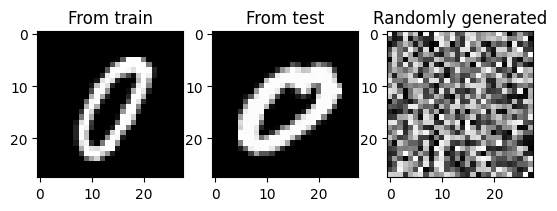

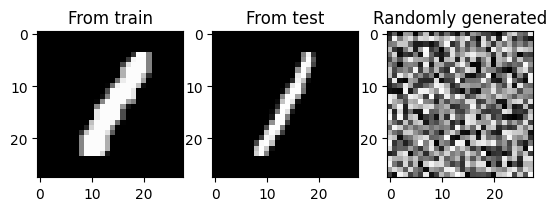

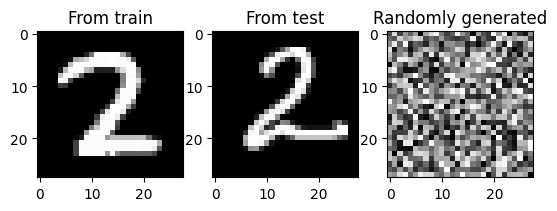

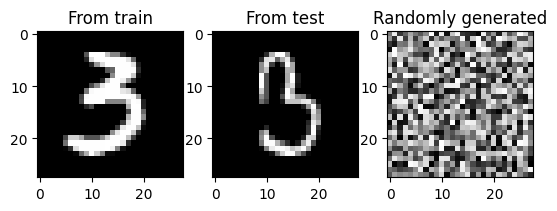

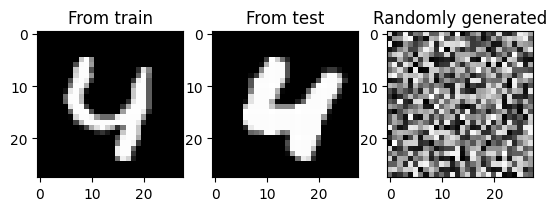

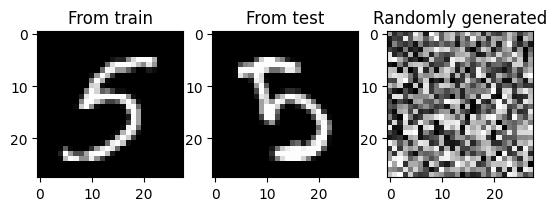

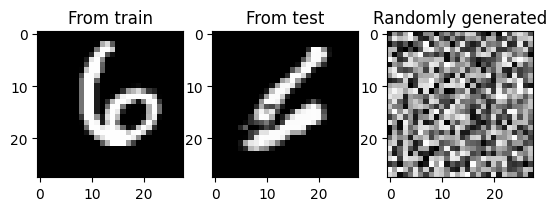

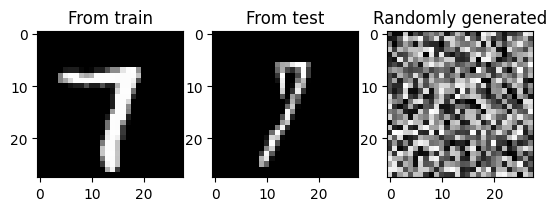

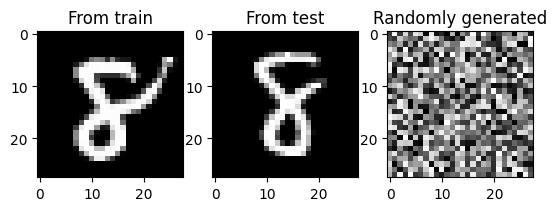

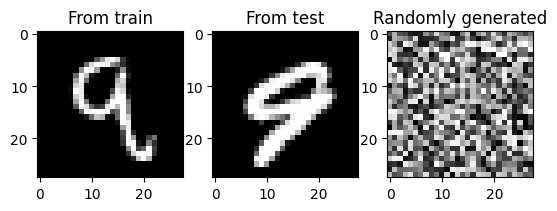

/tmp/ipykernel_46358/2343130714.py:73: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


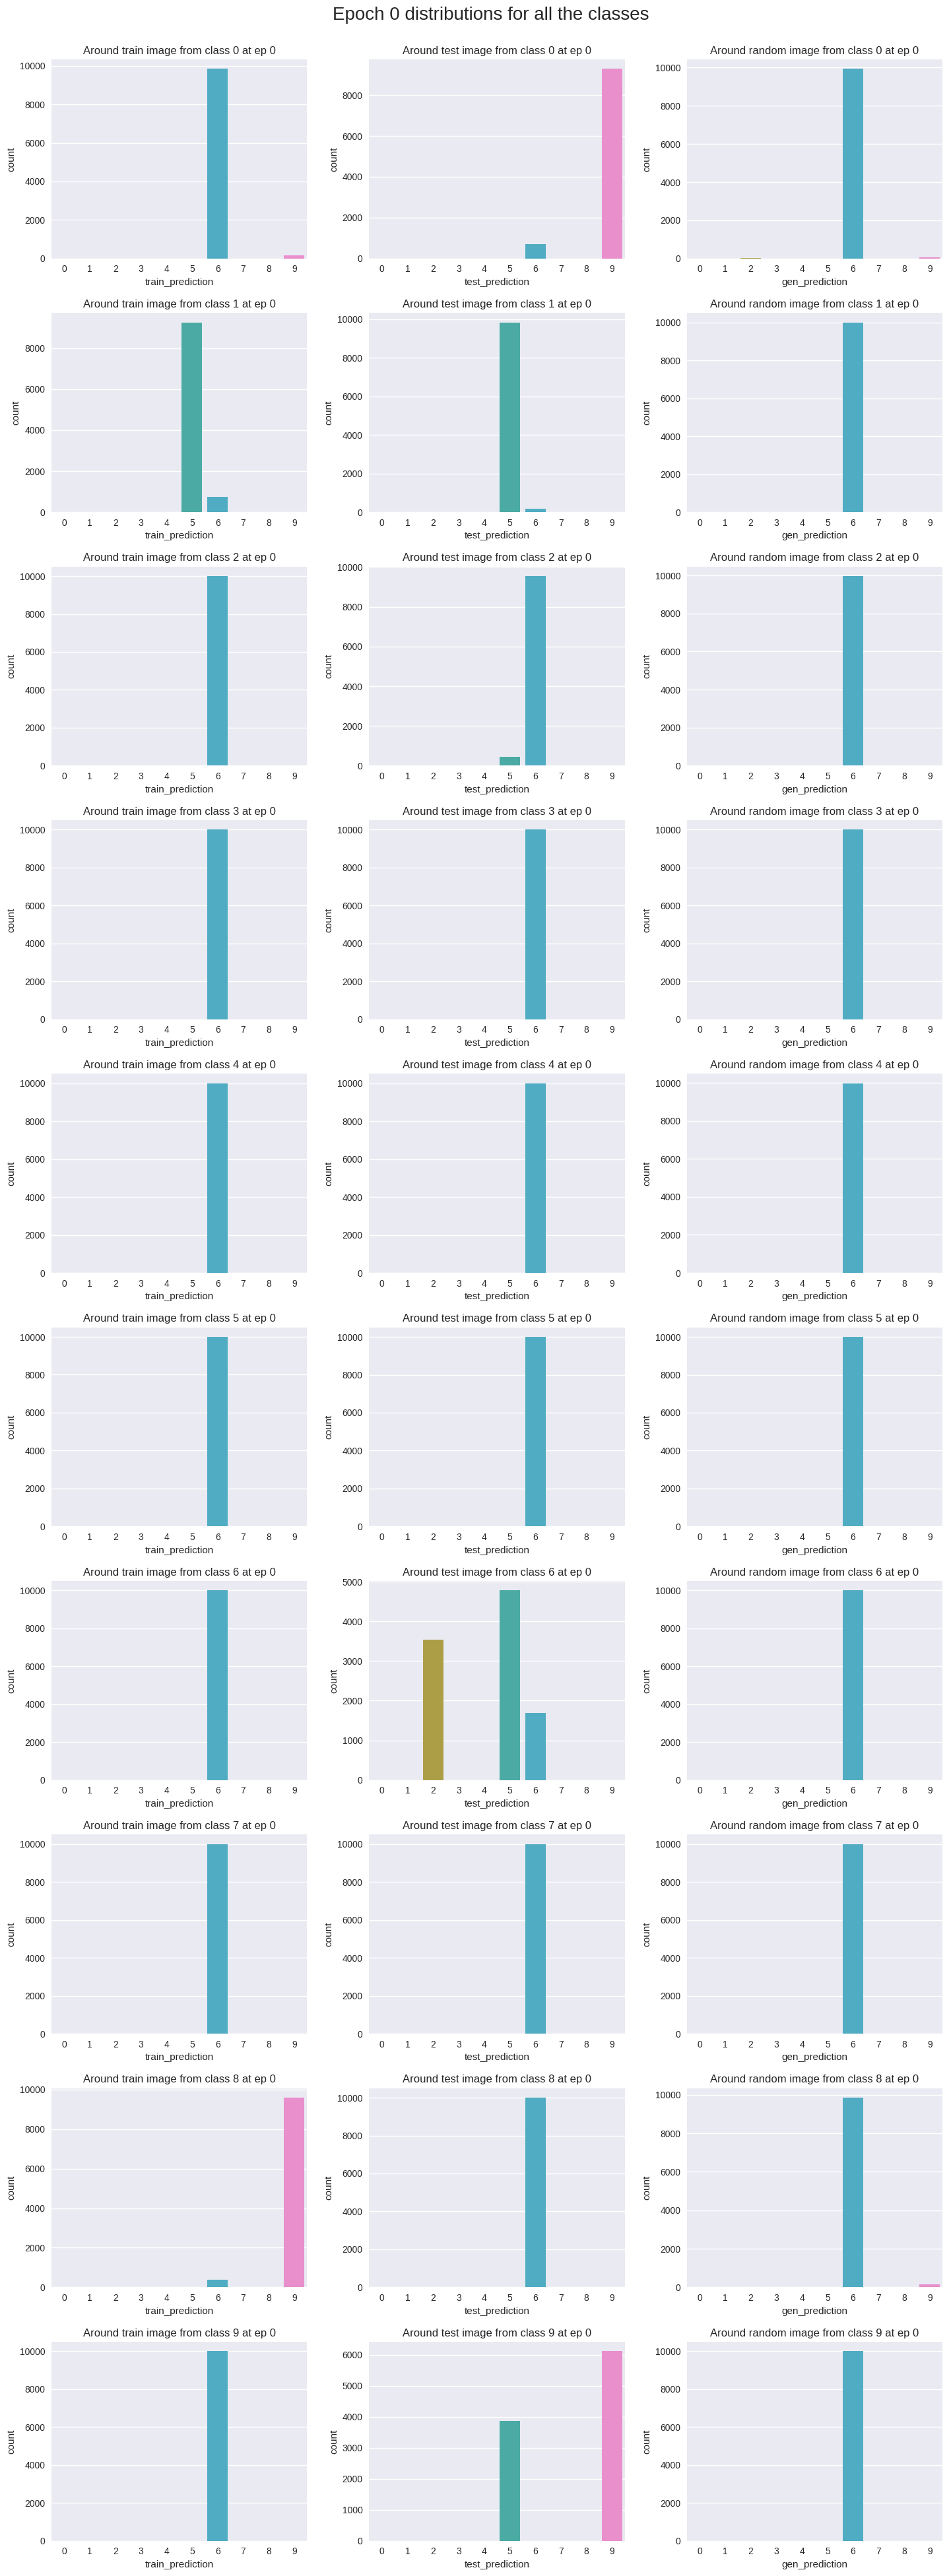

/tmp/ipykernel_46358/2343130714.py:73: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


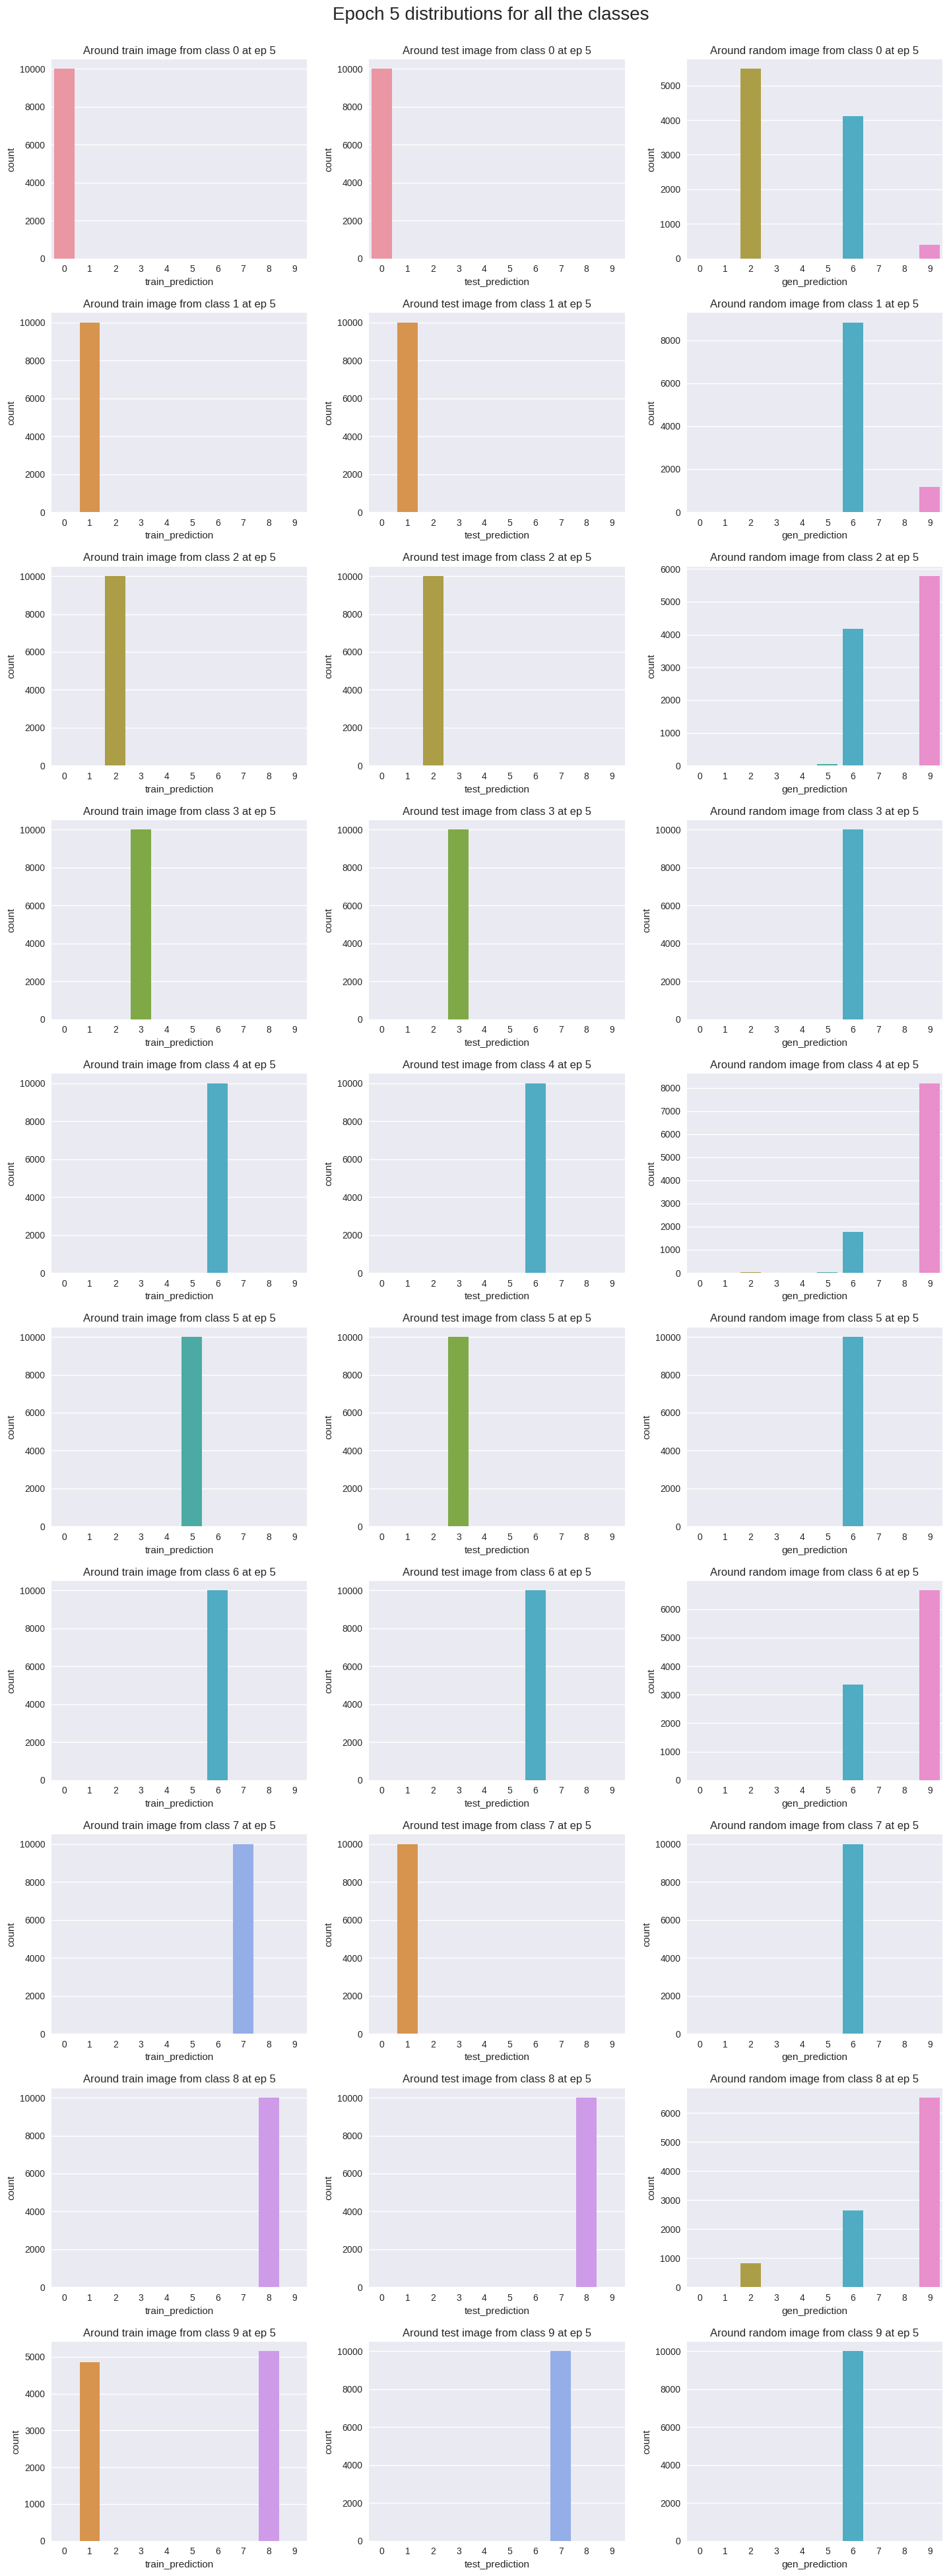

/tmp/ipykernel_46358/2343130714.py:73: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


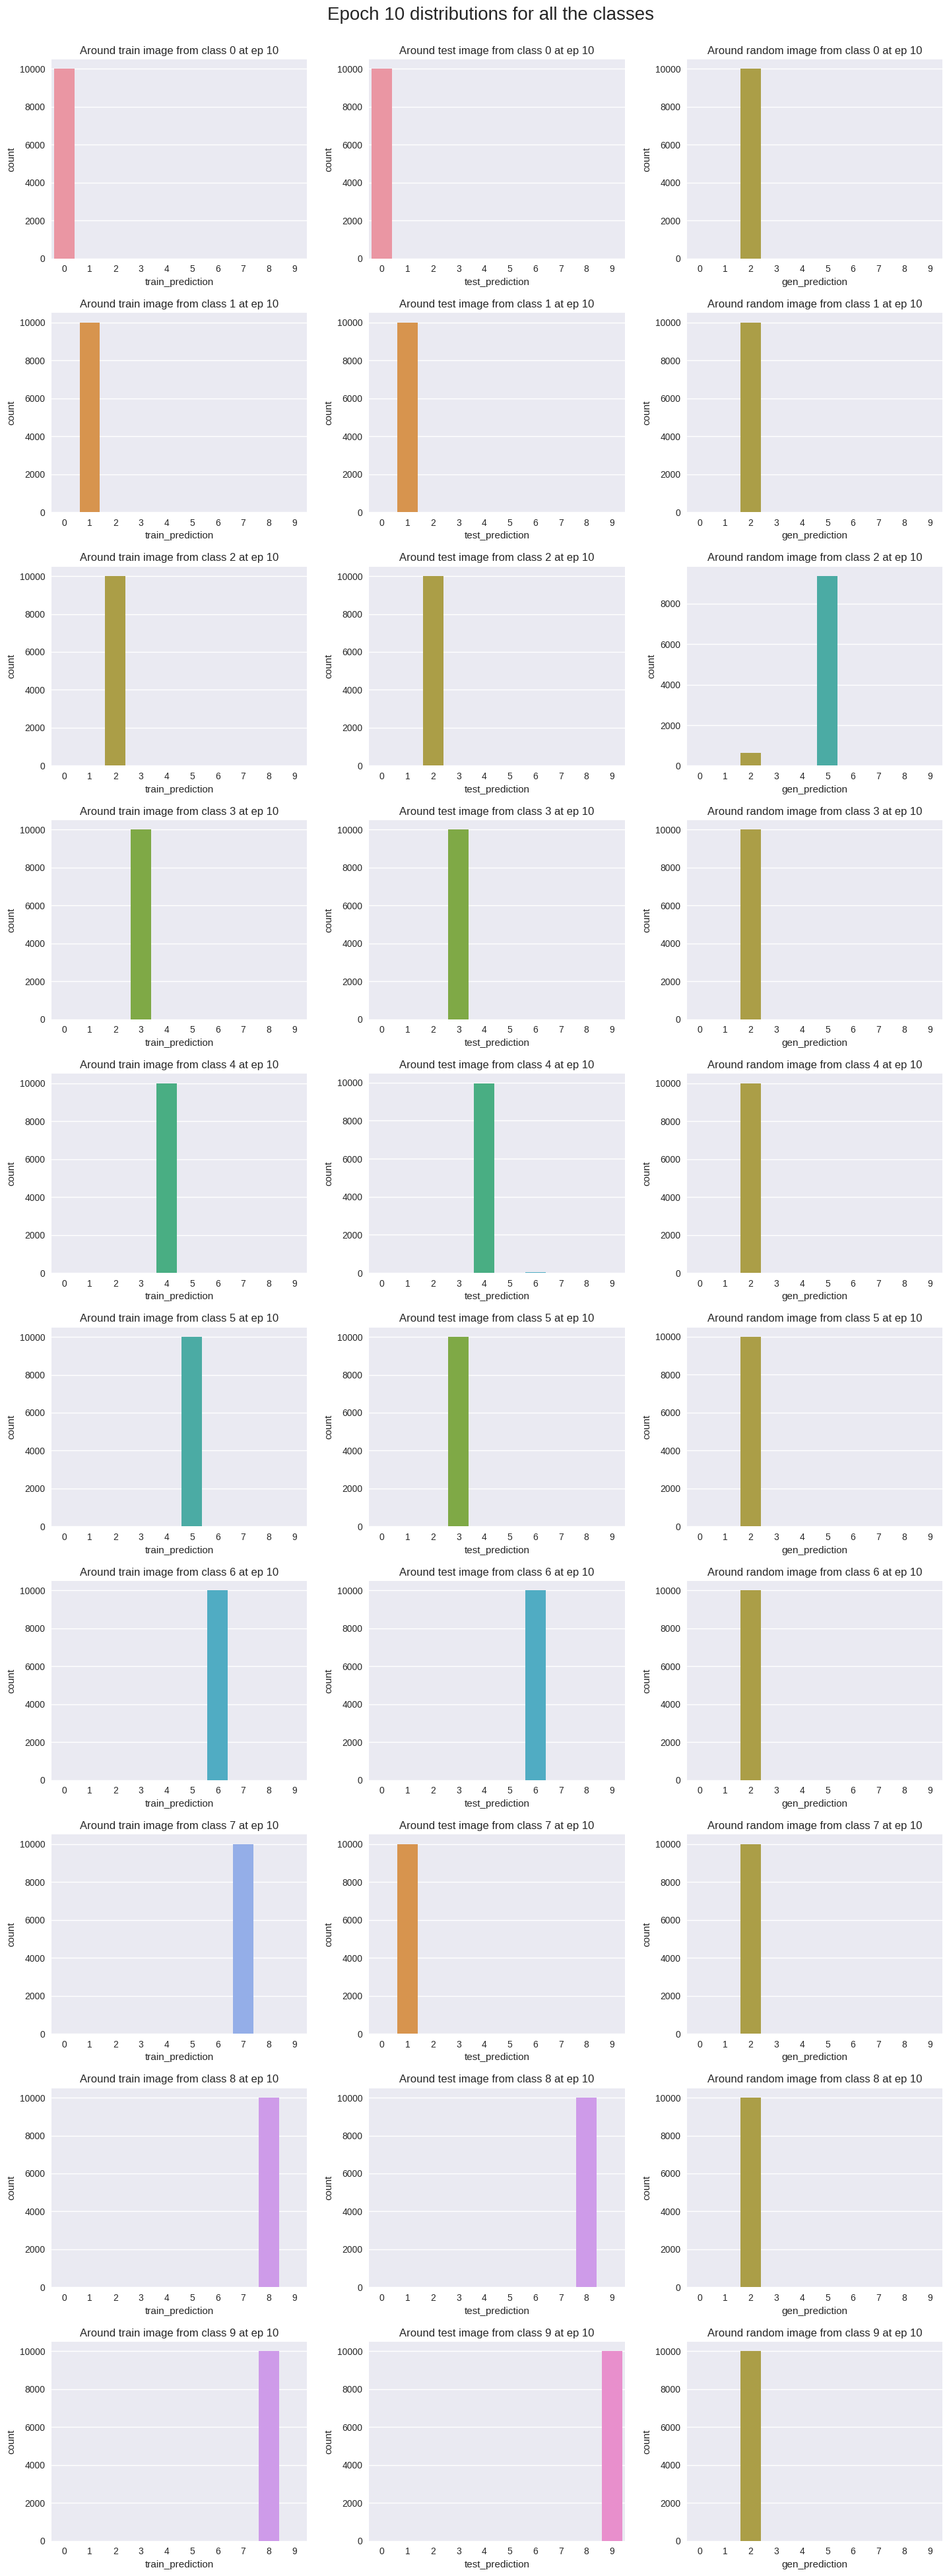

/tmp/ipykernel_46358/2343130714.py:73: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


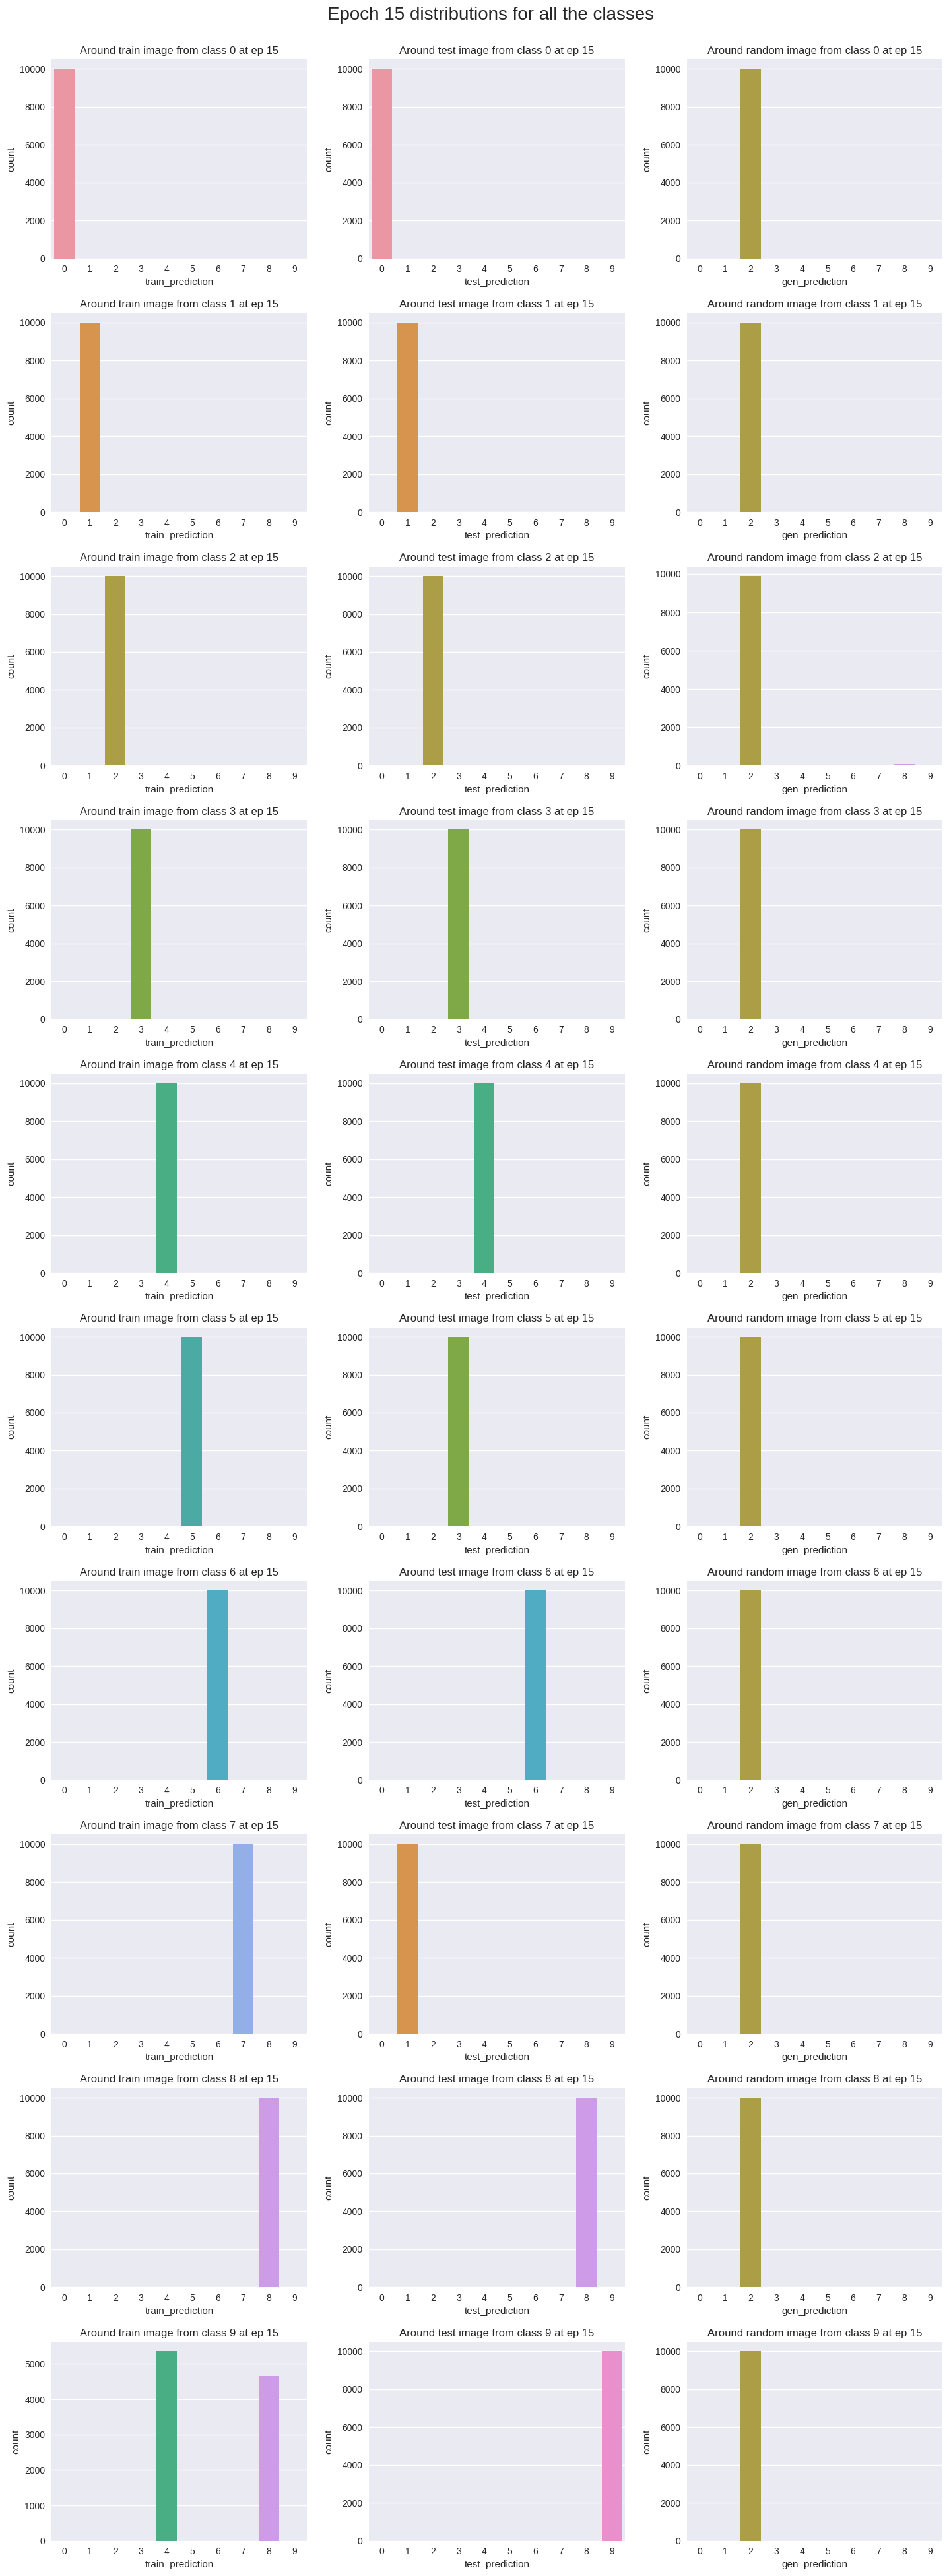

/tmp/ipykernel_46358/2343130714.py:73: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


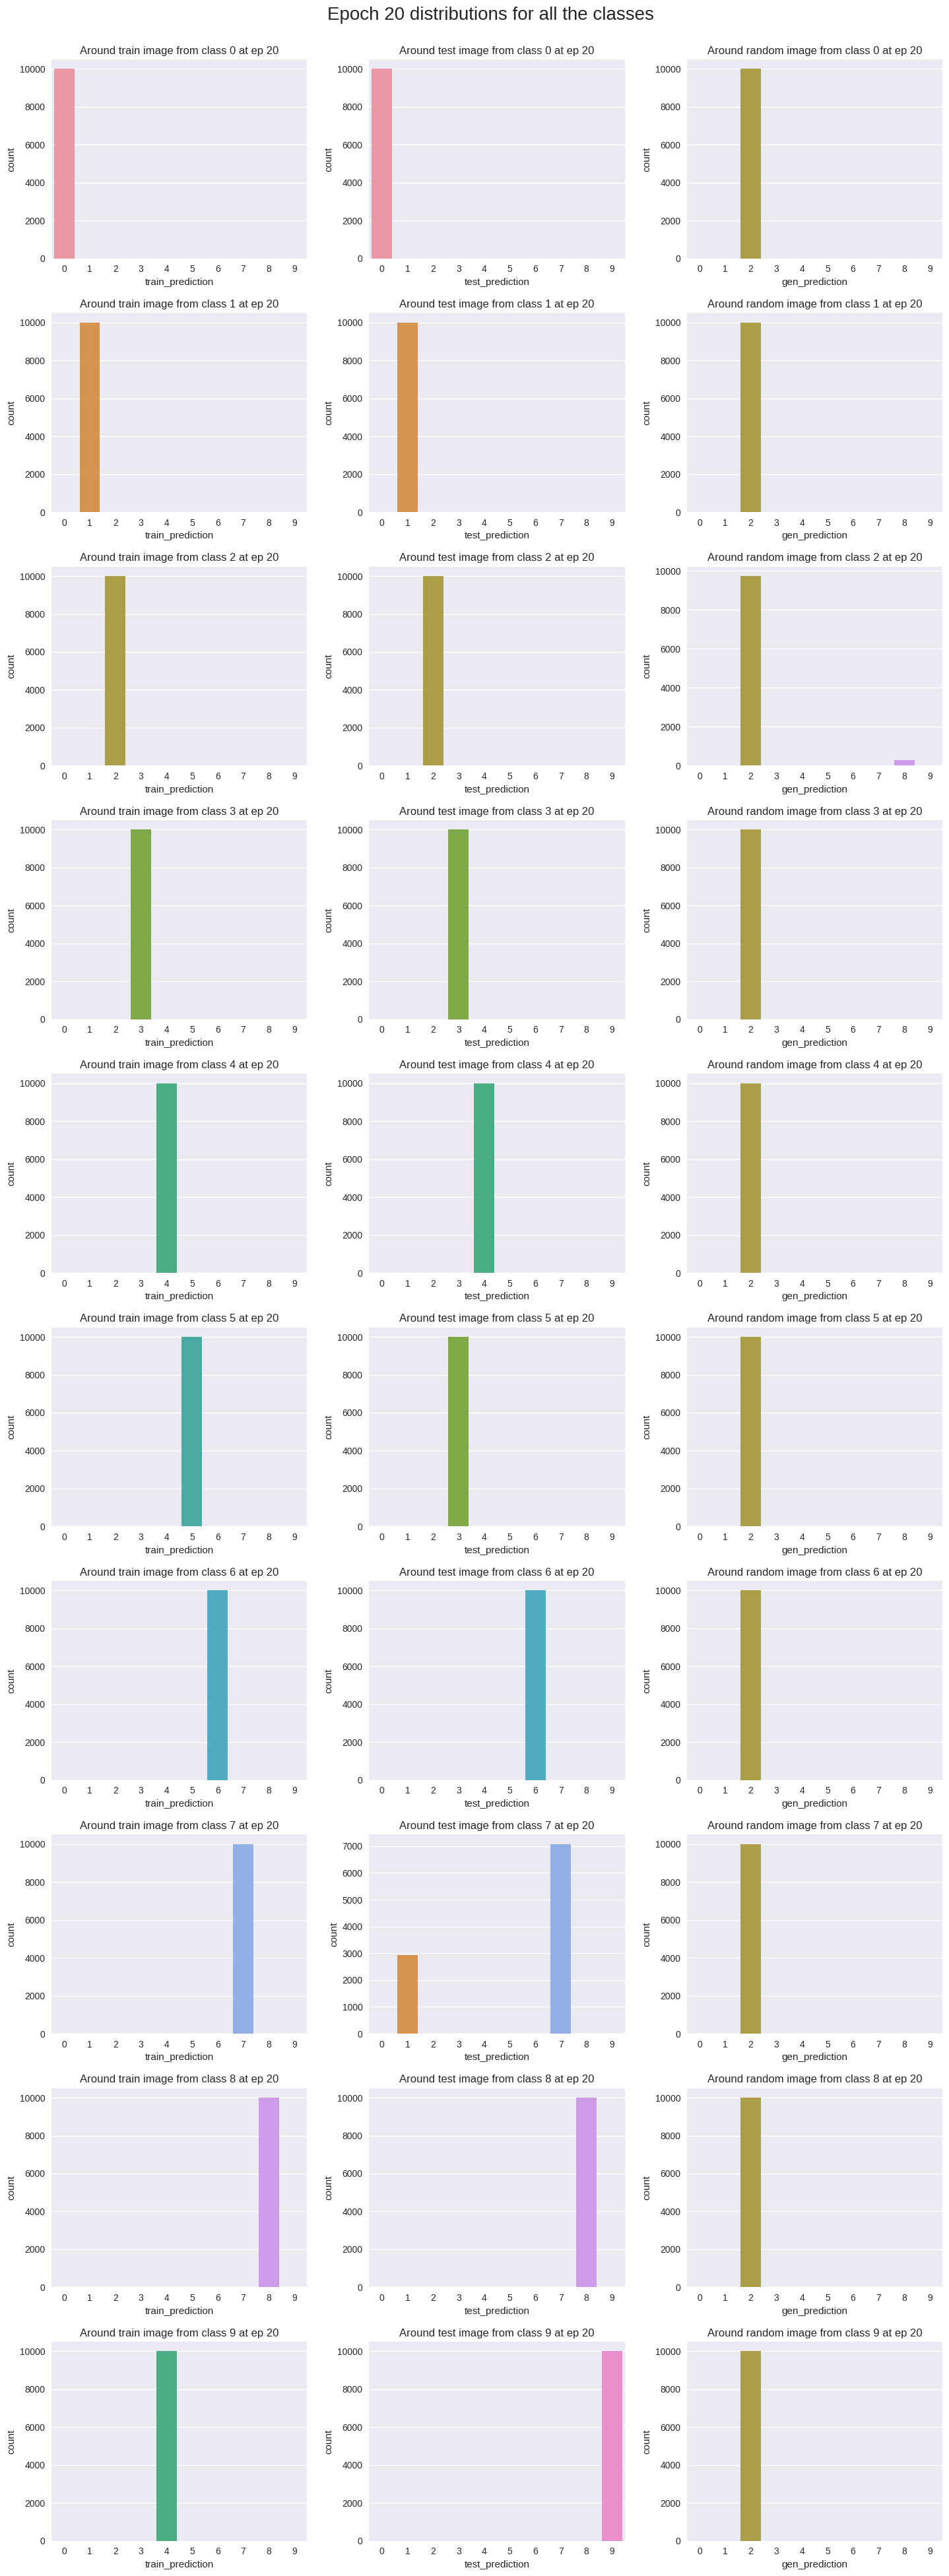

/tmp/ipykernel_46358/2343130714.py:73: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


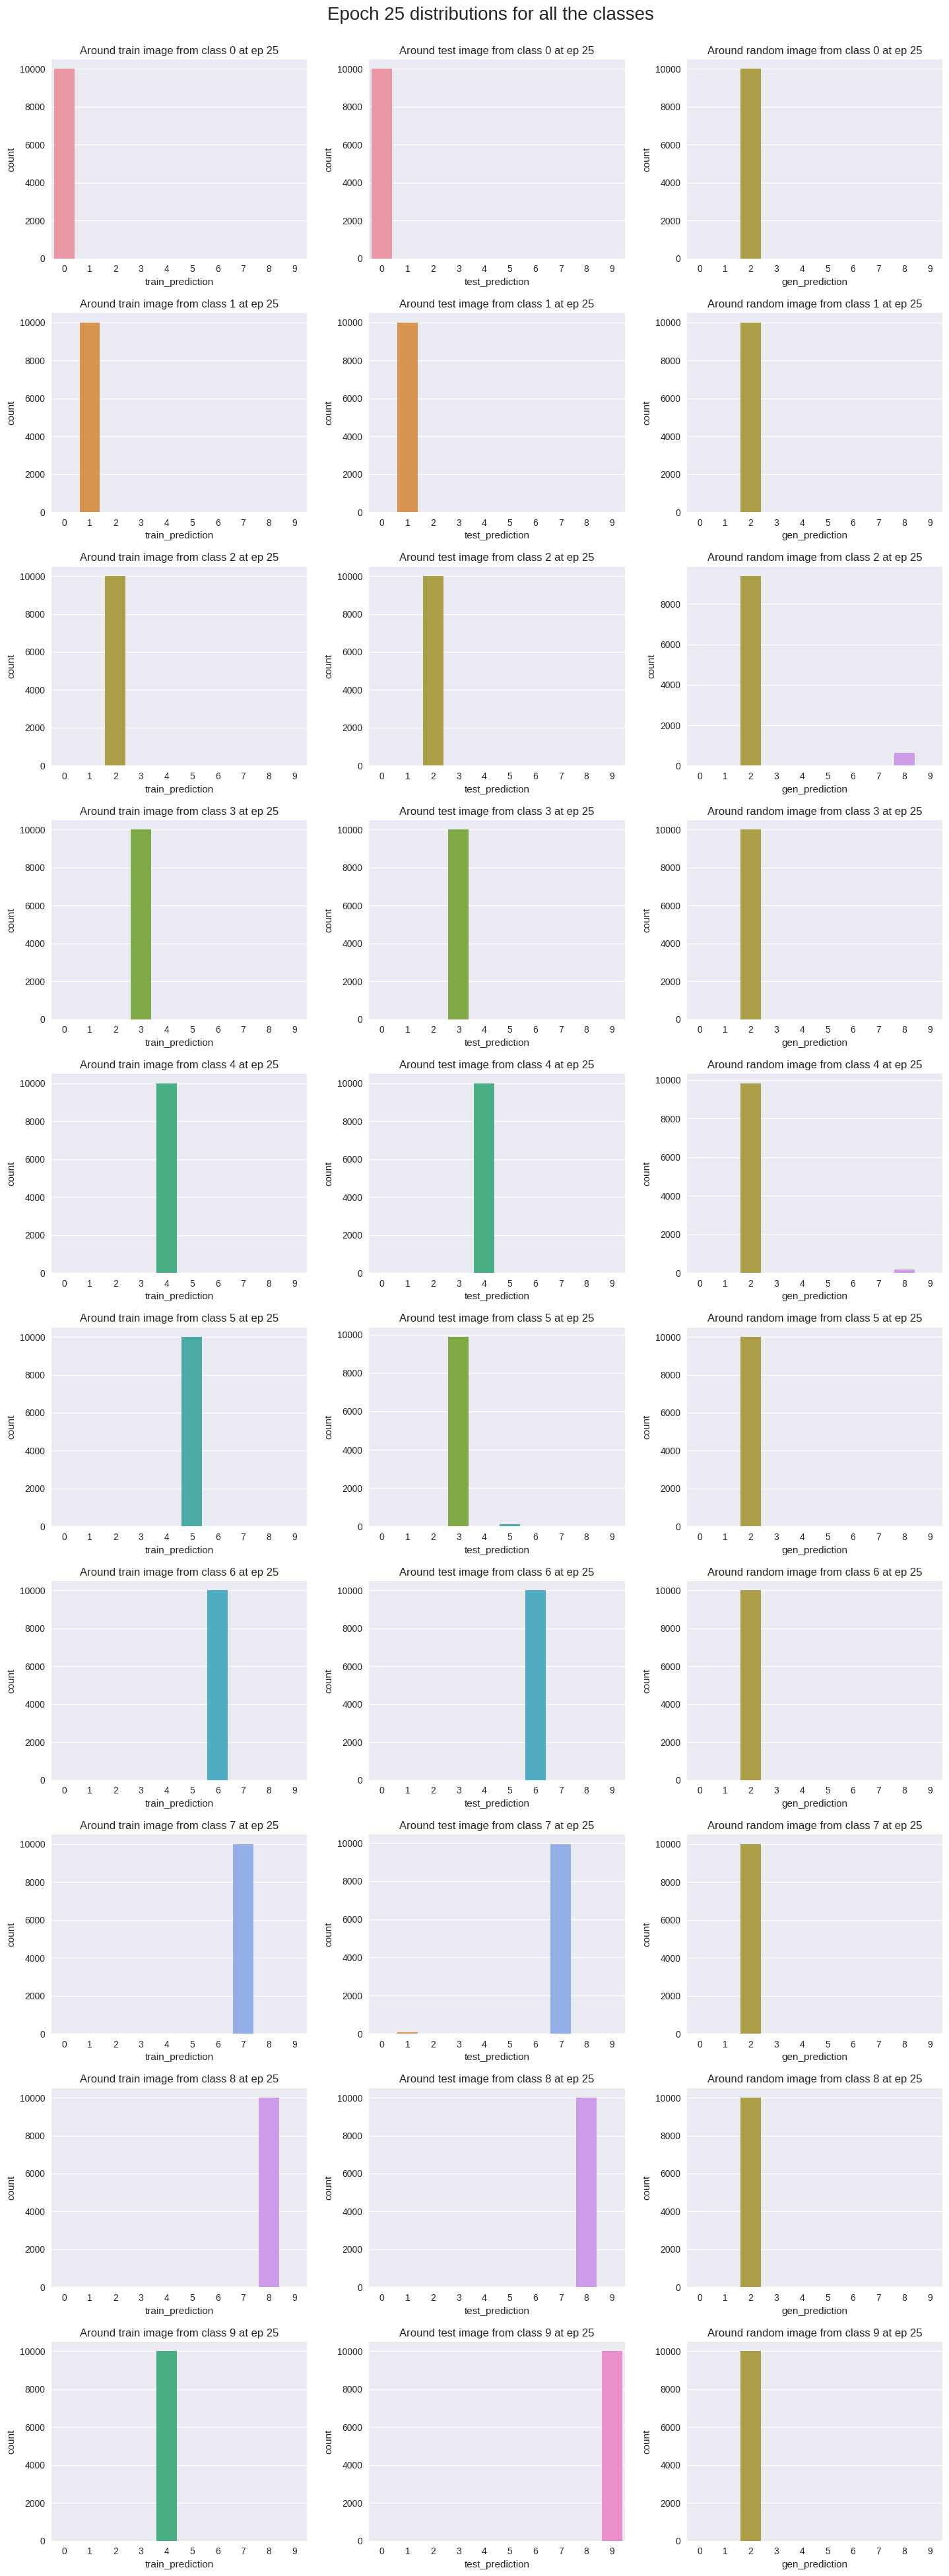

In [16]:
############################Set params###########################
# series_model_name = "FFN19-44-07"
series_model_name = "FFN15-58-32"
model_ep = [0,5,10,15,20,25]
# model_ep = [25]


perturbation_factor = 0.1
num_sampling = 10000
#################################################################
samples = {}

for picked_cls in range(10):
    # collect all the images for one class
    train_cls_idx = train_target==picked_cls    

    sub_train_dataset = train_data[train_cls_idx]
    sub_train_targets = train_target[train_cls_idx]

    test_cls_idx = test_target==picked_cls

    sub_test_dataset = test_data[test_cls_idx]
    sub_test_targets = test_target[test_cls_idx].to(device)
    
    
    # randomly pick one image from train and test set respectively
    random_train_idx = random.randint(0, len(sub_train_targets)-1)
    random_test_idx = random.randint(0, len(sub_test_targets)-1)


    random_train_img = sub_train_dataset[random_train_idx]
    random_test_img = sub_test_dataset[random_test_idx]
    # randomly generate an image
    random_gen_img = torch.rand(1, 28, 28)

    plt.style.use('default')
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(random_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0].title.set_text('From train')
    axarr[1].imshow(random_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1].title.set_text('From test')
    axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[2].title.set_text('Randomly generated')
    # plt.title(f"Train, test, random generate")
    plt.show()
    plt.close(f)

    # get the neighborhood of the images by adding little noise/pertubation
    extended_train = random_train_img.repeat(num_sampling,1,1,1)
    extended_test = random_test_img.repeat(num_sampling,1,1,1)
    extended_gen = random_gen_img.repeat(num_sampling,1,1,1)

    train_noise = torch.normal(0, 1, size=extended_train.shape) * perturbation_factor
    test_noise = torch.normal(0, 1, size=extended_test.shape) * perturbation_factor
    gen_noise = torch.normal(0, 1, size=extended_gen.shape) * perturbation_factor

    extended_train = extended_train + train_noise
    extended_test = extended_test + test_noise
    extended_gen = extended_gen + gen_noise
    
    
    # save the neighborhood of images for each class
    samples[picked_cls] = (extended_train, extended_test, extended_gen)

# For each model along the training process from untrained(epoch=0) to half trained to trained, 
# predict the neighborhood by untrained and trained models and draw the distribution
for ep in model_ep:
    
    new_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
    new_model.load_state_dict(torch.load(series_model_name +f"-ep{ep}"))
    

    plt.style.use('seaborn')
    f, axarr = plt.subplots(10, 3,  figsize=(15, 40))
    f.tight_layout(pad=4)
    f.subplots_adjust(top=0.96)
    plt.suptitle(f"Epoch {ep} distributions for all the classes",fontsize=20)
    for cls in samples:
        with torch.no_grad():
            train_outputs = new_model(samples[cls][0].to(device)).argmax(dim=1)
            test_outputs = new_model(samples[cls][1].to(device)).argmax(dim=1)
            gen_outputs = new_model(samples[cls][2].to(device)).argmax(dim=1)

        train_df = pd.DataFrame(train_outputs.cpu().numpy(), columns = ['train_prediction'])
        test_df = pd.DataFrame(test_outputs.cpu().numpy(), columns = ['test_prediction'])
        gen_df = pd.DataFrame(gen_outputs.cpu().numpy(), columns = ['gen_prediction'])
        sns.countplot(data=train_df, x="train_prediction", order=list(range(10)), ax=axarr[cls][0])
        sns.countplot(data=test_df, x="test_prediction", order=list(range(10)), ax=axarr[cls][1])
        sns.countplot(data=gen_df, x="gen_prediction", order=list(range(10)), ax=axarr[cls][2])
        axarr[cls][0].set_title(f'Around train image from class {cls} at ep {ep}')
        axarr[cls][1].set_title(f'Around test image from class {cls} at ep {ep}')
        axarr[cls][2].set_title(f'Around random image from class {cls} at ep {ep}')
    plt.show()
    plt.close(f)


### Only trained and untrained model

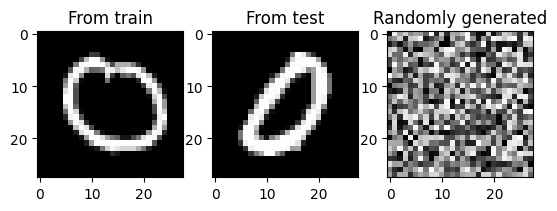

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


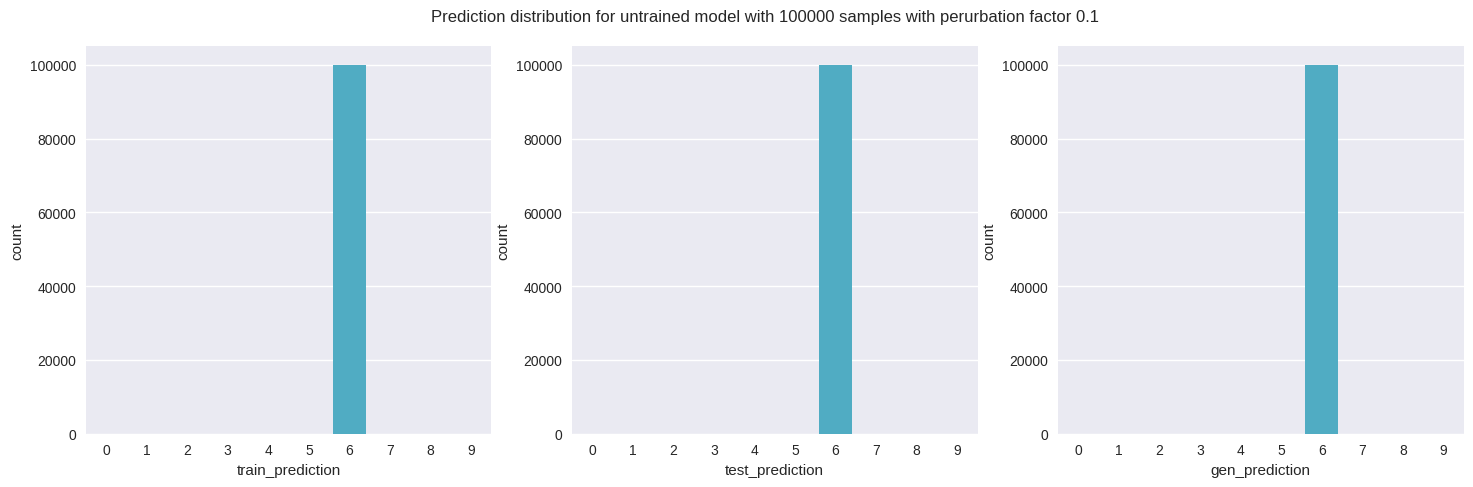

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


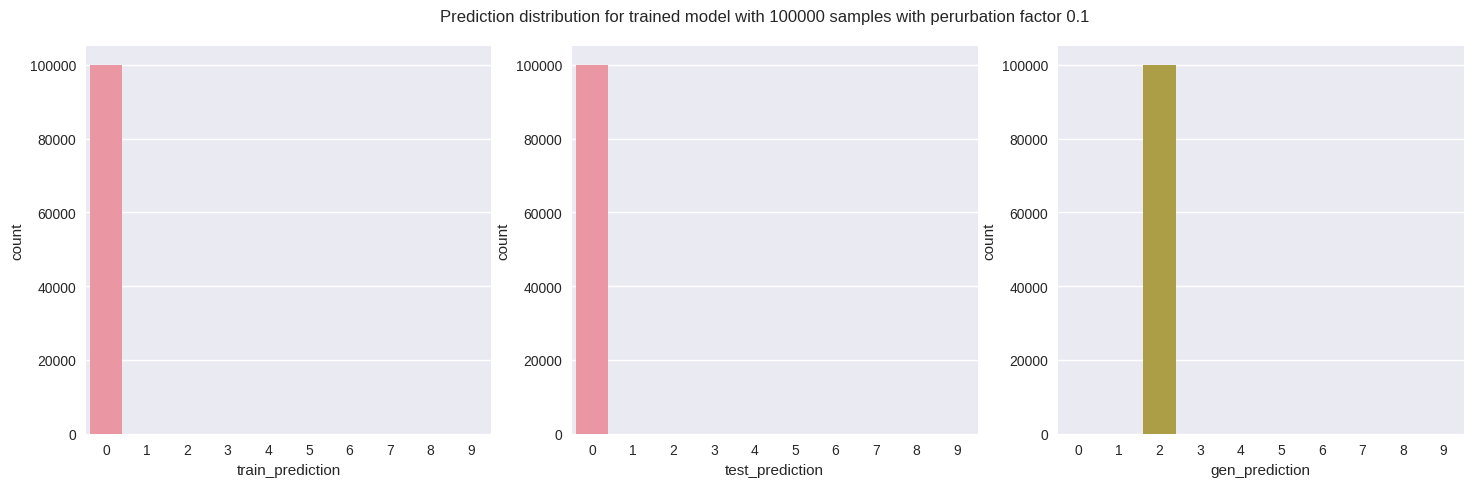

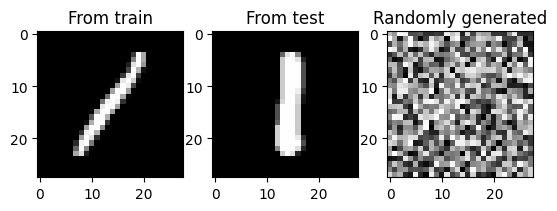

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


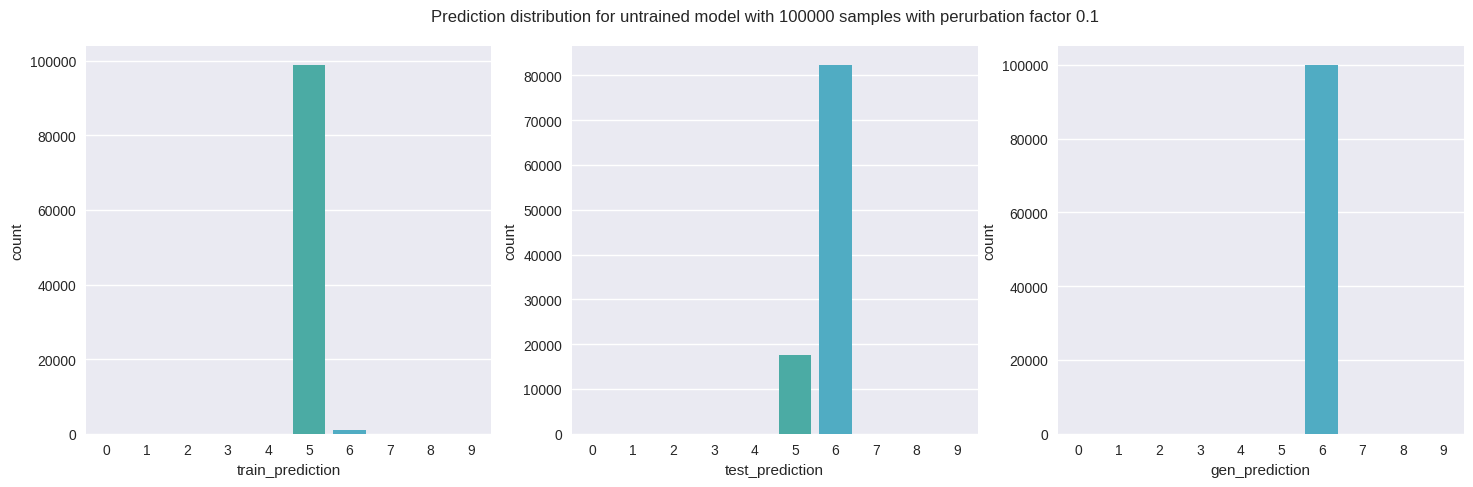

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


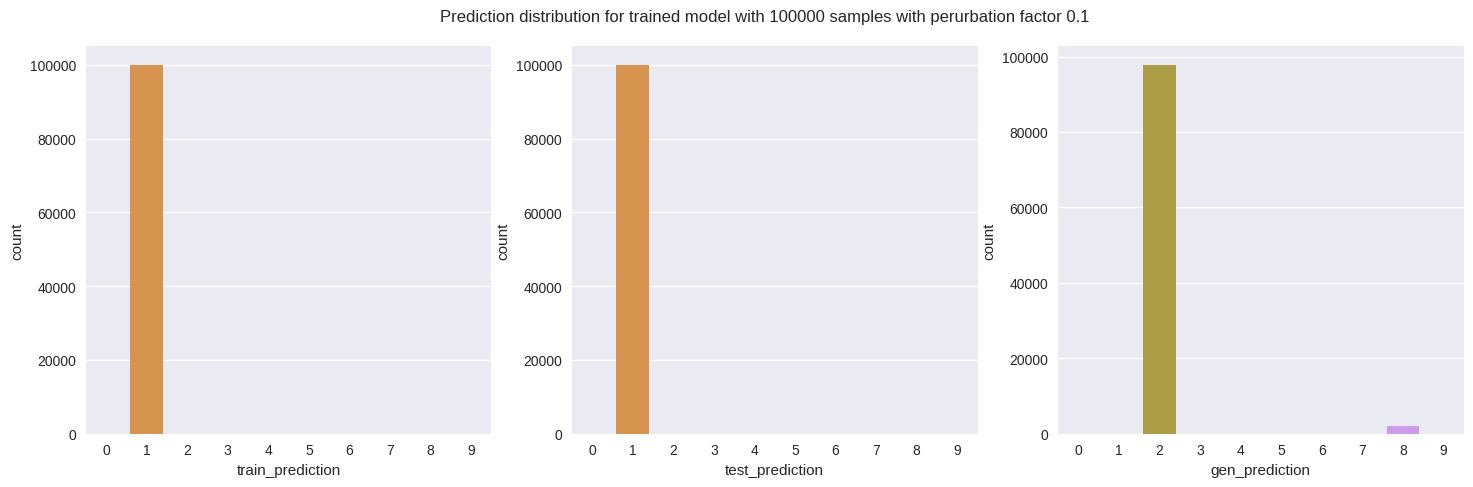

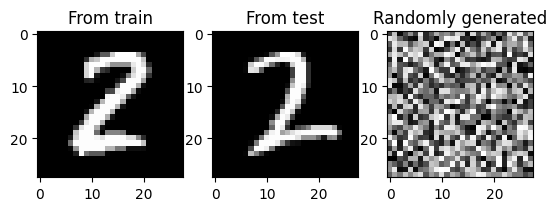

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


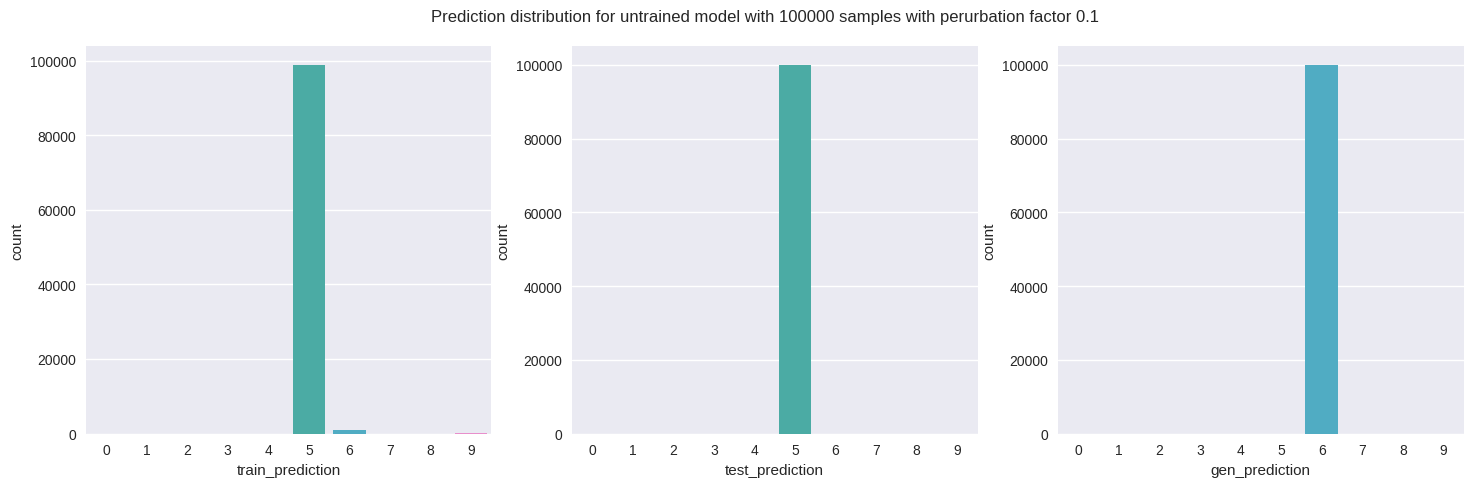

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


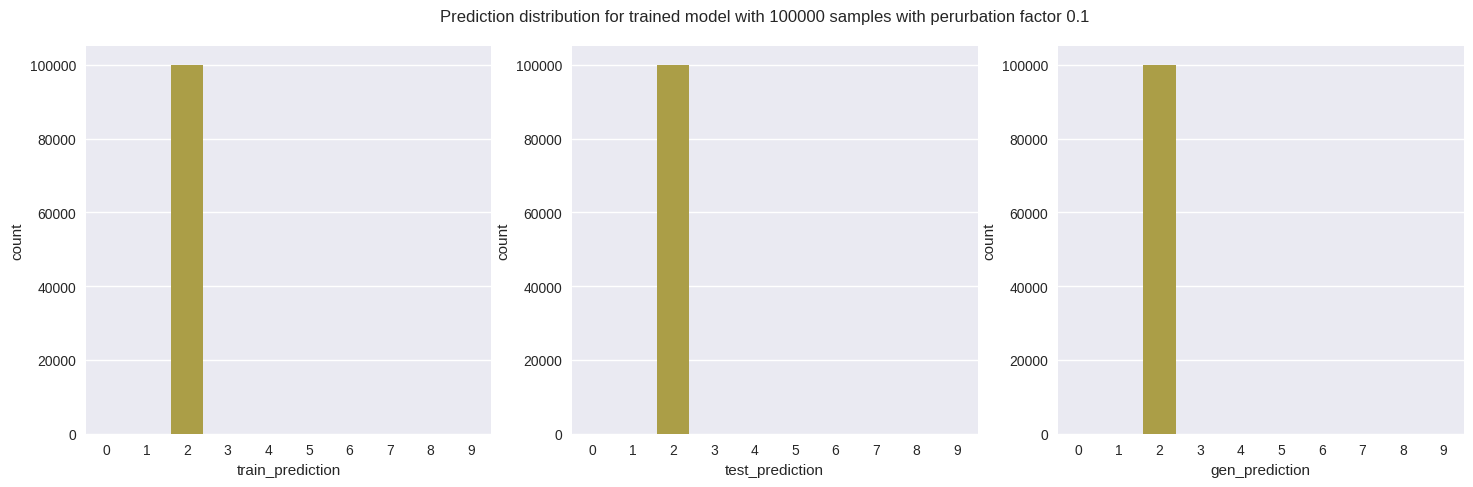

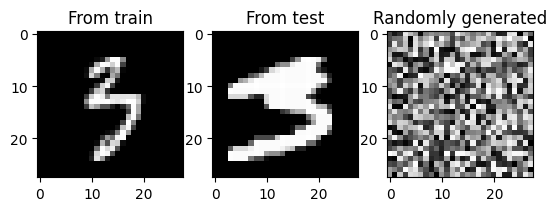

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


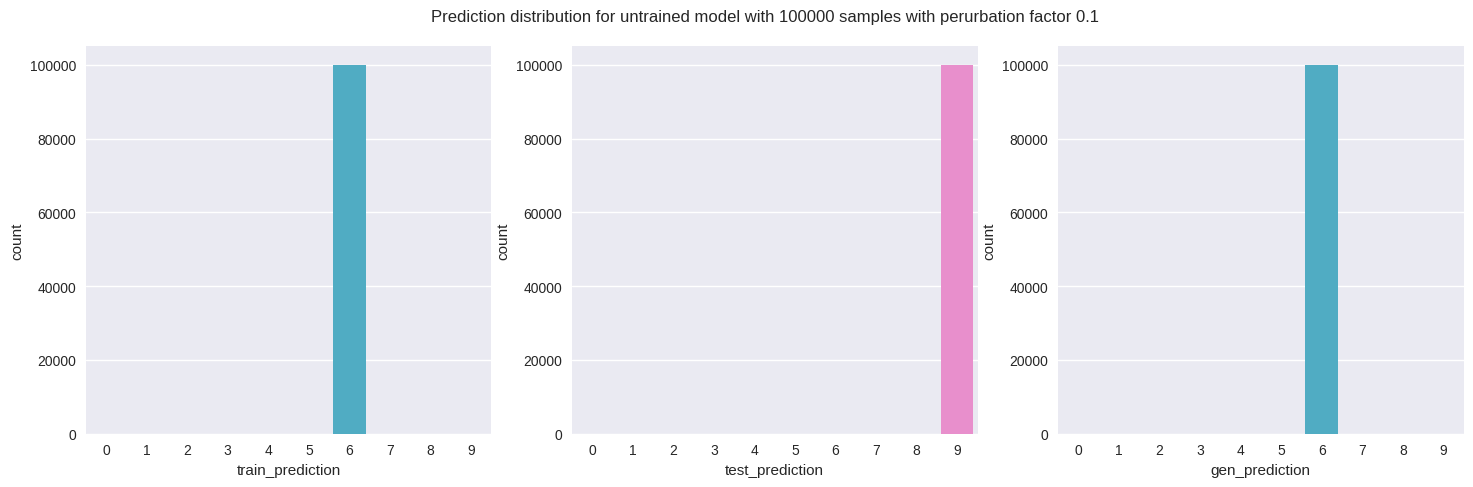

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


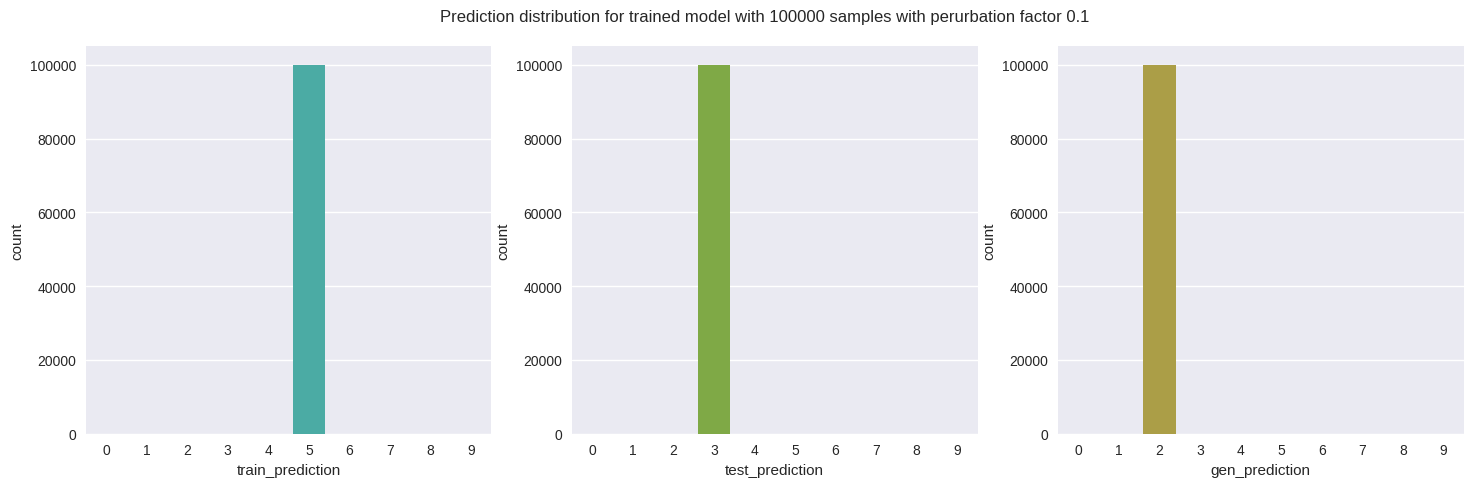

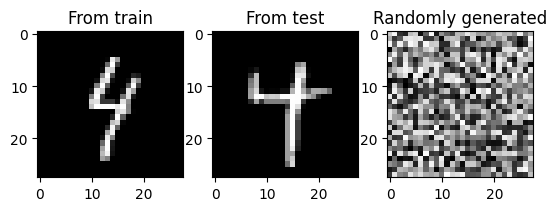

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


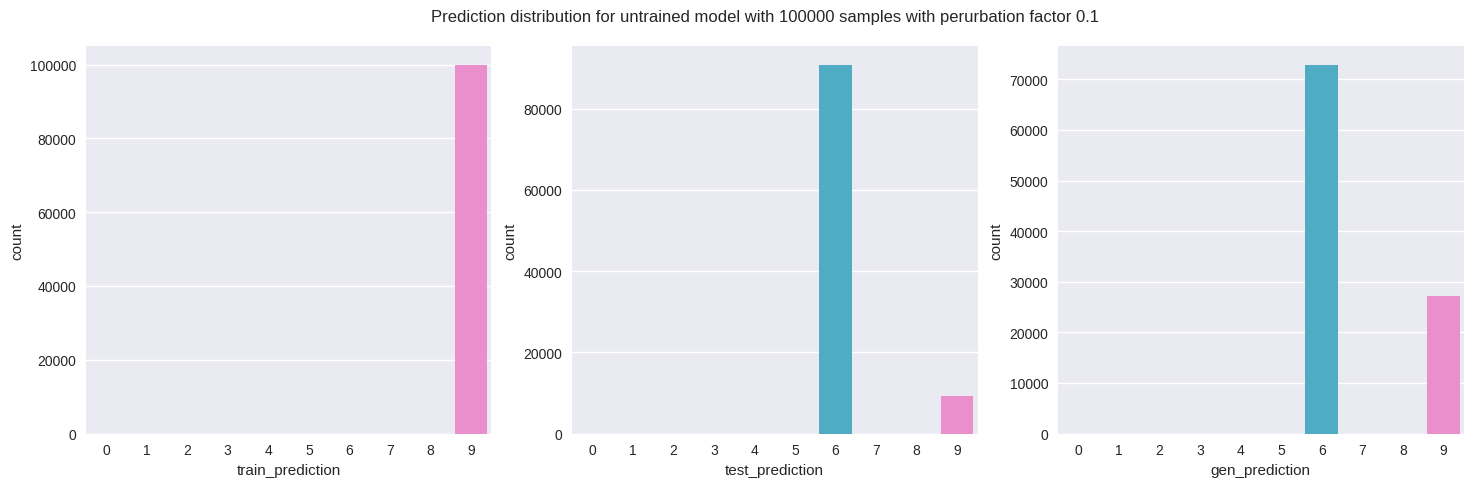

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


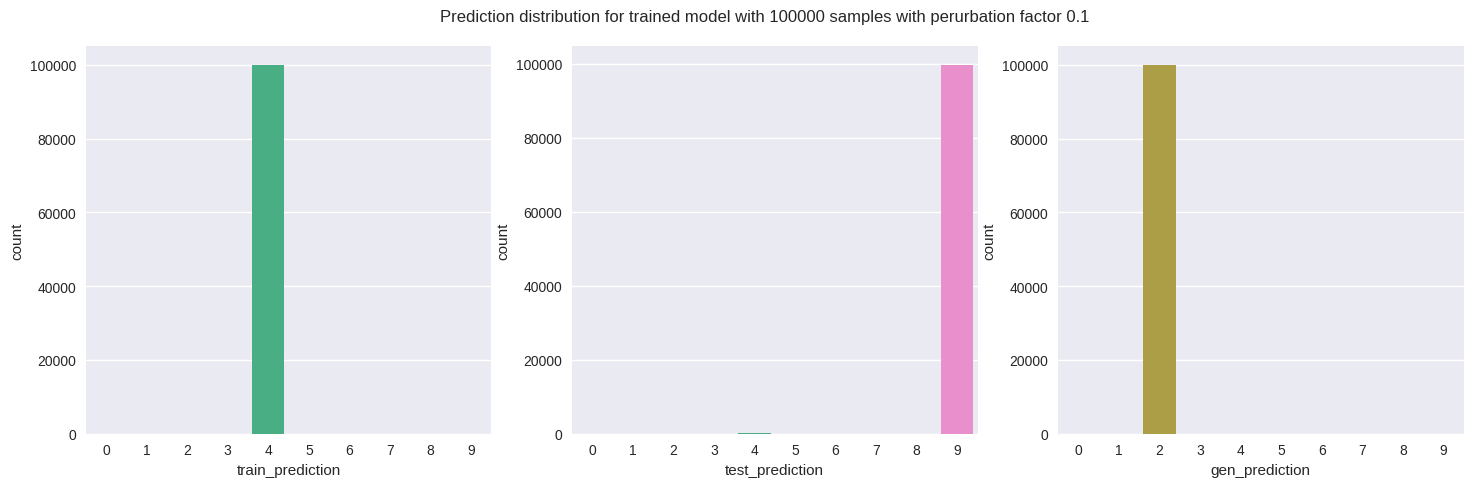

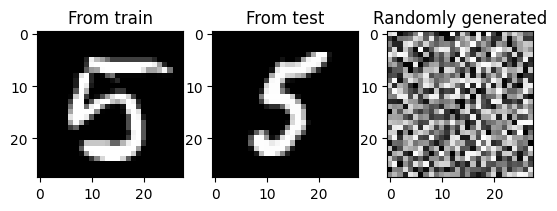

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


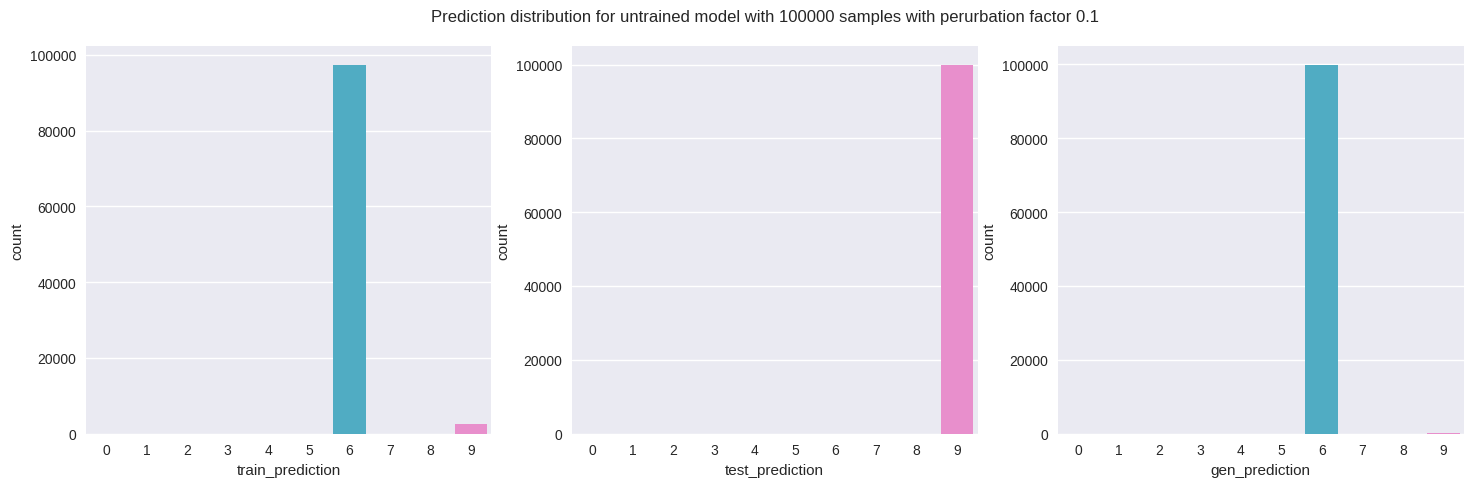

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


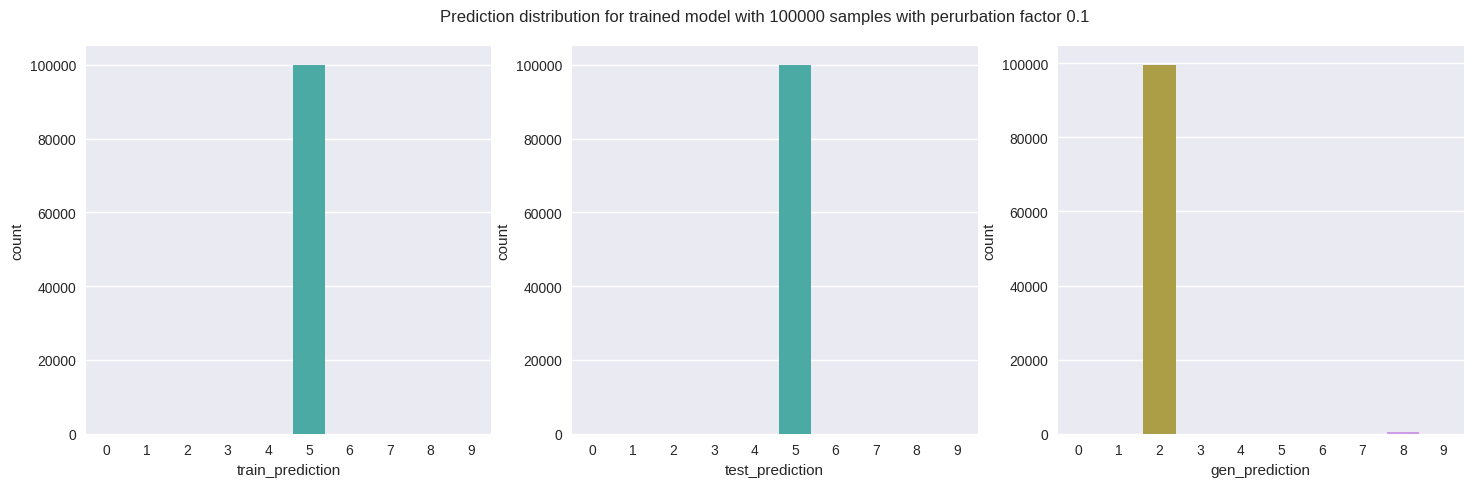

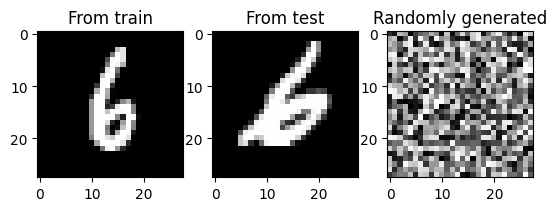

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


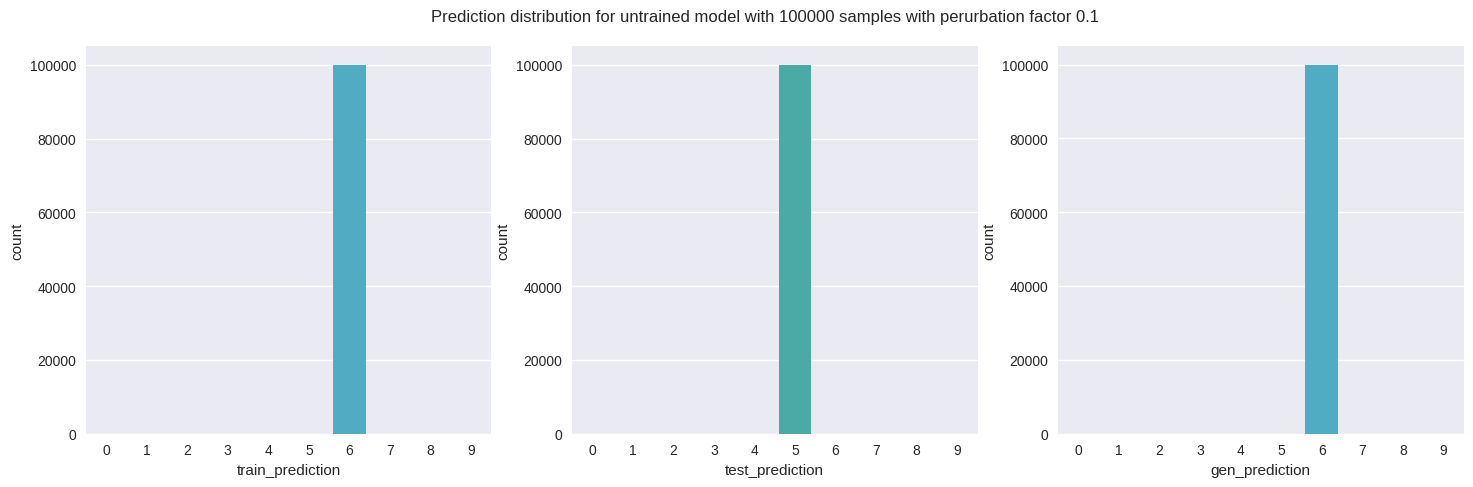

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


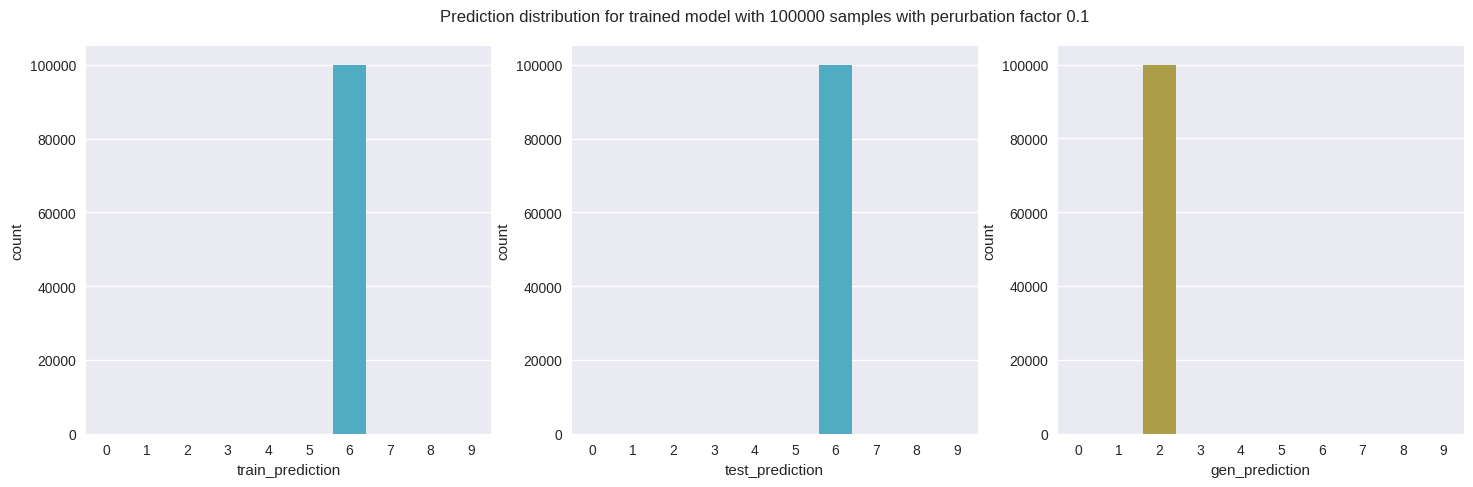

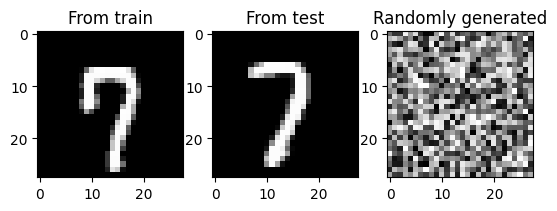

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


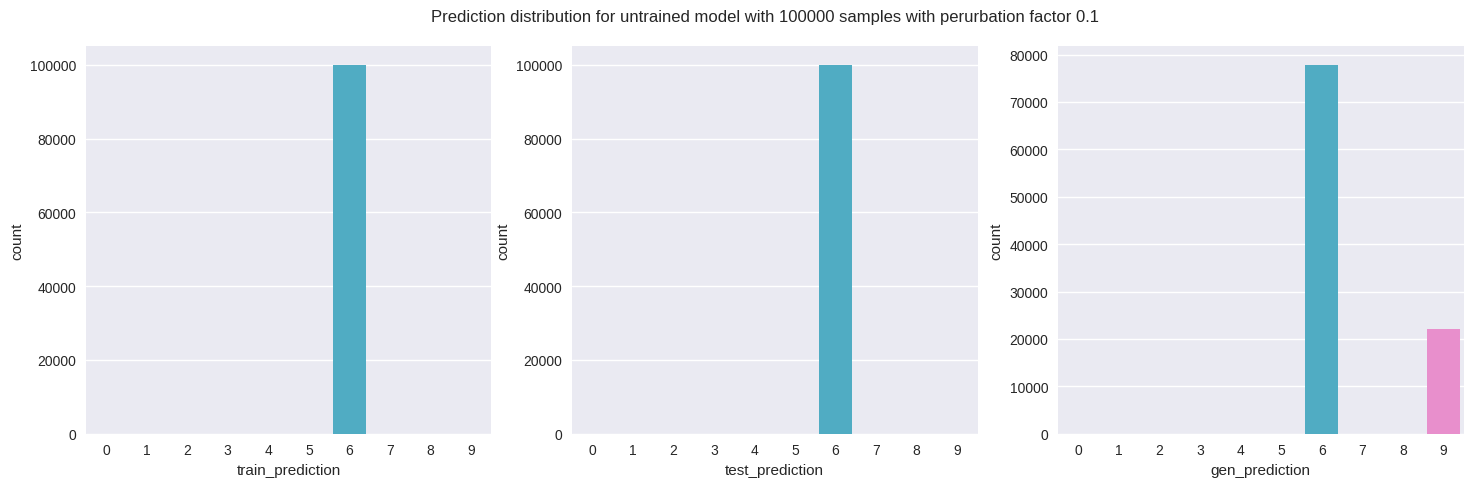

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


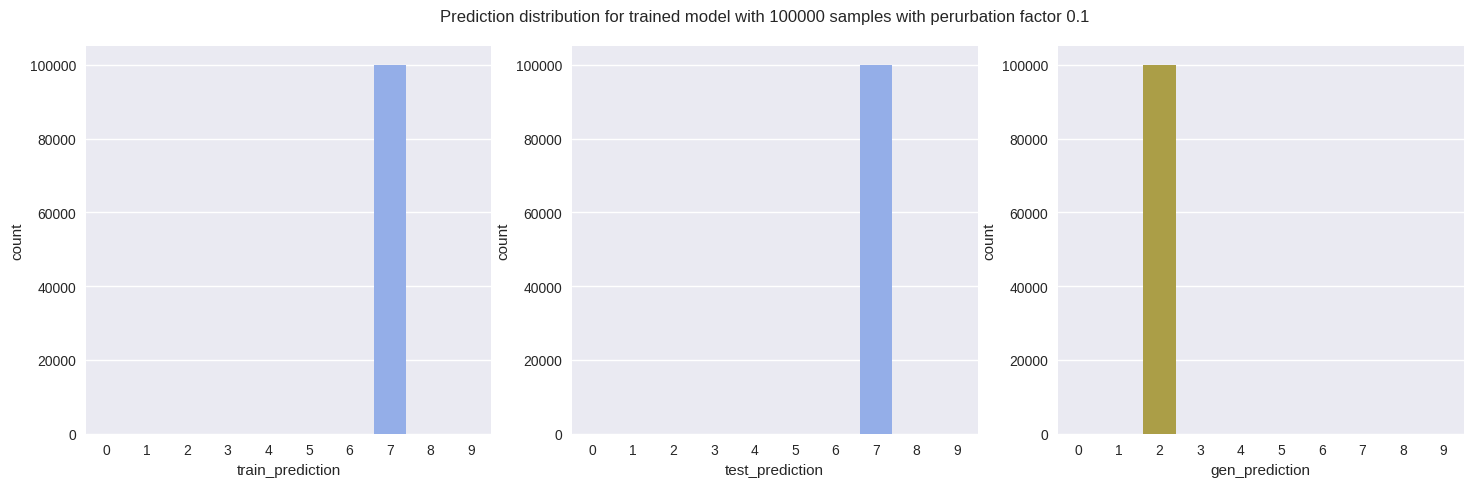

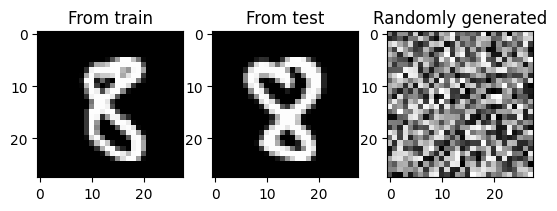

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


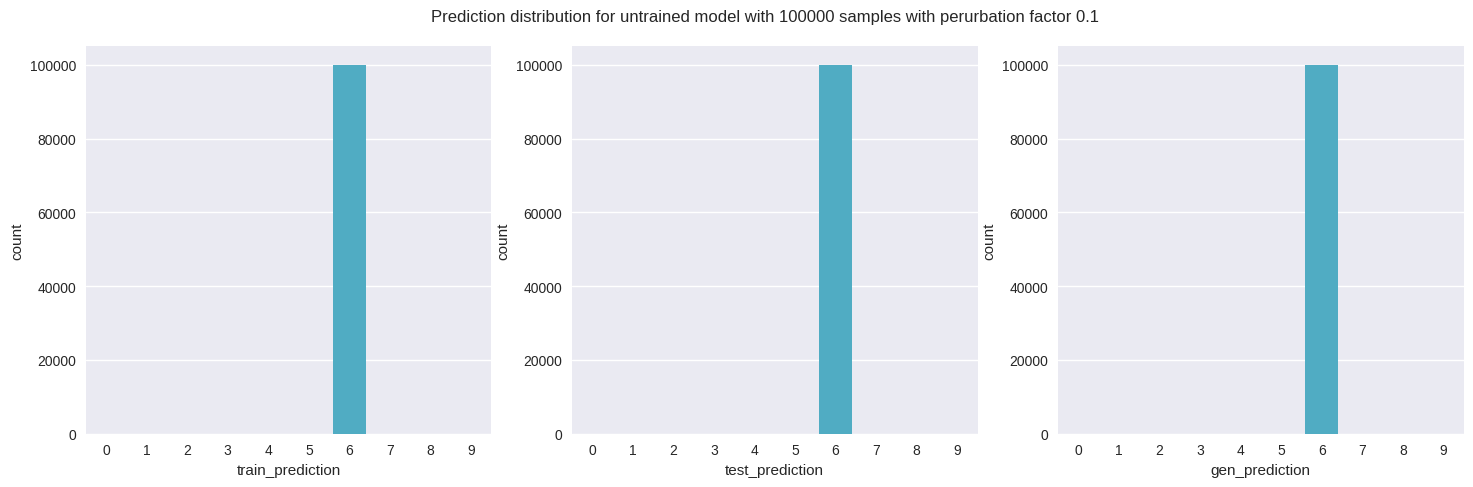

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


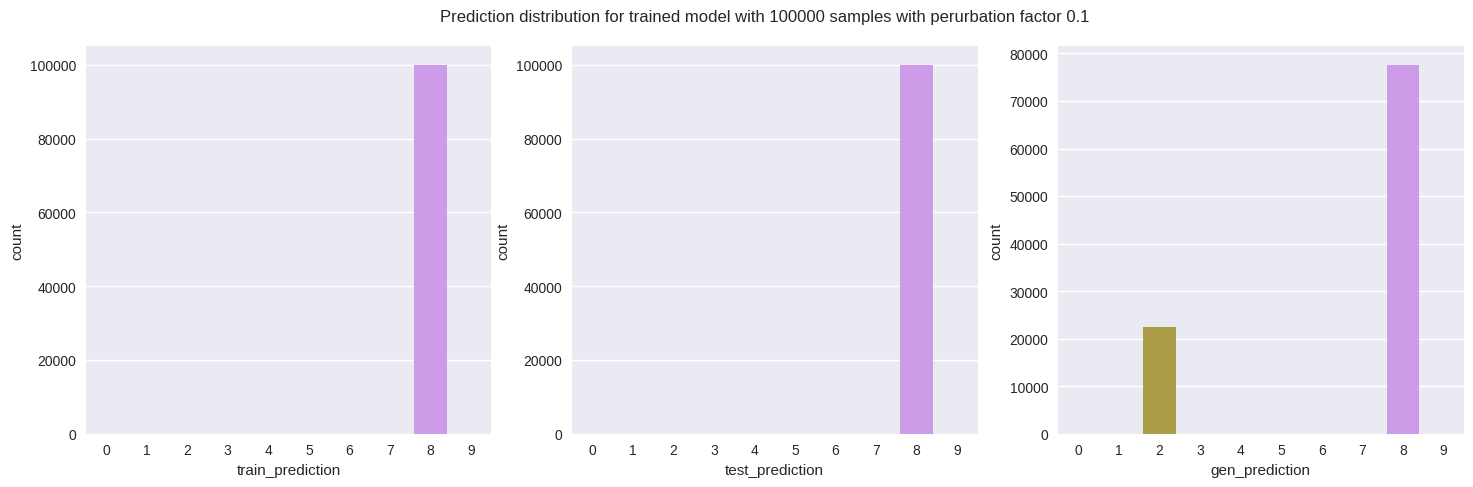

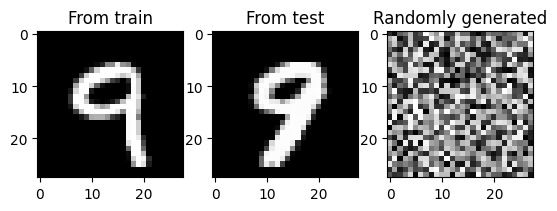

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


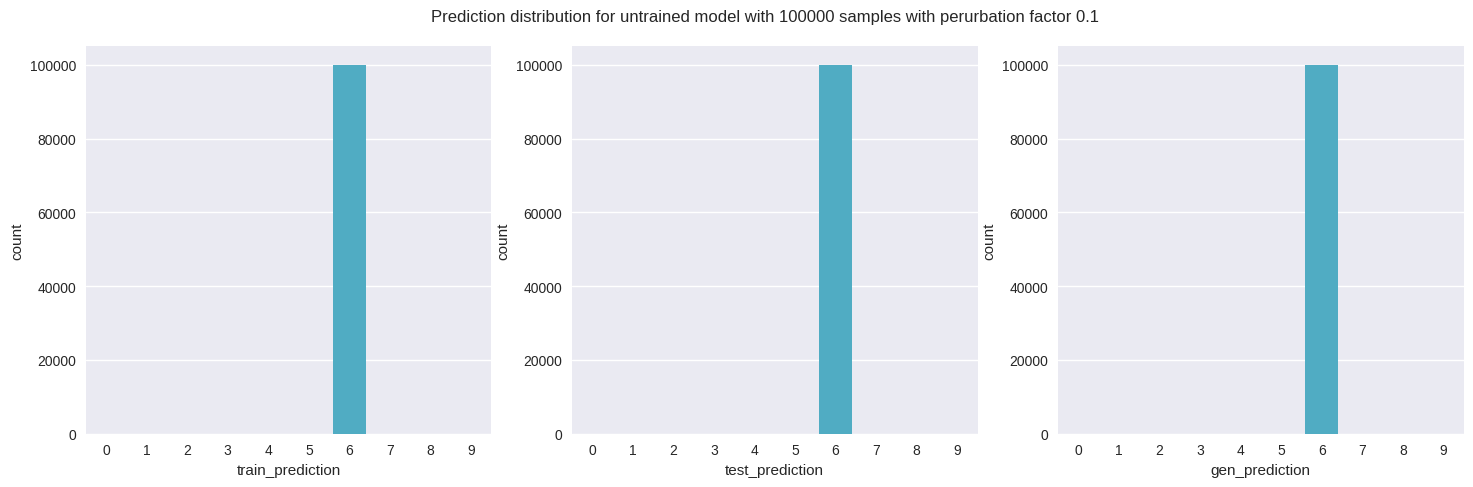

/tmp/ipykernel_46358/4236698273.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


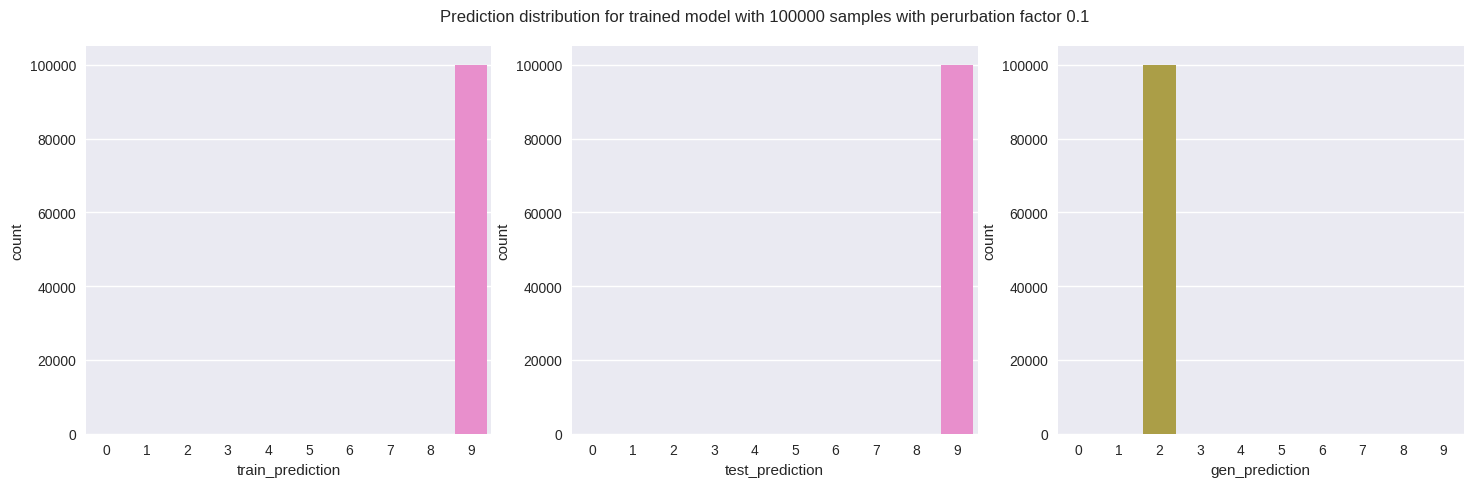

In [17]:

################################set params#################################
perturbation_factor = 0.1
num_sampling = 100000
###########################################################################


for picked_cls in range(10):
    
    # collect all the images for one class
    train_cls_idx = train_target==picked_cls    

    sub_train_dataset = train_data[train_cls_idx].to(device)
    sub_train_targets = train_target[train_cls_idx].to(device)

    test_cls_idx = test_target==picked_cls

    sub_test_dataset = test_data[test_cls_idx].to(device)
    sub_test_targets = test_target[test_cls_idx].to(device)
    
    
    # randomly pick one image from train and test set respectively
    random_train_idx = random.randint(0, len(sub_train_targets)-1)
    random_test_idx = random.randint(0, len(sub_test_targets)-1)


    random_train_img = sub_train_dataset[random_train_idx]
    random_test_img = sub_test_dataset[random_test_idx]
    
    # randomly generate an image
    random_gen_img = torch.rand(1, 28, 28)

    plt.style.use('default')
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(random_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0].title.set_text('From train')
    axarr[1].imshow(random_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1].title.set_text('From test')
    axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[2].title.set_text('Randomly generated')
    # plt.title(f"Train, test, random generate")
    plt.show()
    plt.close(f)
    
    # get the neighborhood of the images by adding little noise/pertubation
    extended_train = random_train_img.repeat(num_sampling,1,1,1).to(device)
    extended_test = random_test_img.repeat(num_sampling,1,1,1).to(device)
    extended_gen = random_gen_img.repeat(num_sampling,1,1,1).to(device)

    train_noise = torch.normal(0, 1, size=extended_train.shape) * perturbation_factor
    test_noise = torch.normal(0, 1, size=extended_test.shape) * perturbation_factor
    gen_noise = torch.normal(0, 1, size=extended_gen.shape) * perturbation_factor

    extended_train = extended_train + train_noise.to(device)
    extended_test = extended_test + test_noise.to(device)
    extended_gen = extended_gen + gen_noise.to(device)


    # predict the neighborhood by untrained and trained models and draw the distribution
    with torch.no_grad():
        train_outputs = untrained_model(extended_train).argmax(dim=1)
        test_outputs = untrained_model(extended_test).argmax(dim=1)
        gen_outputs = untrained_model(extended_gen).argmax(dim=1)
    draw_distribution(train_outputs, test_outputs, gen_outputs, f"Prediction distribution for untrained model with {num_sampling} samples with perurbation factor {perturbation_factor}")

    with torch.no_grad():
        train_outputs = model(extended_train).argmax(dim=1)
        test_outputs = model(extended_test).argmax(dim=1)
        gen_outputs = model(extended_gen).argmax(dim=1)
    draw_distribution(train_outputs, test_outputs, gen_outputs, f"Prediction distribution for trained model with {num_sampling} samples with perurbation factor {perturbation_factor}")





### Some other checks

#### same neighborhood of train, test and randomly generated images, different untrained models
- Randomly pick one iamge from train and test set respectively, and randomly generated image.
- Get their neighborhood by adding little noise/pertibution.
- Do the prediction on different untrained models with the same set of neighborhoods

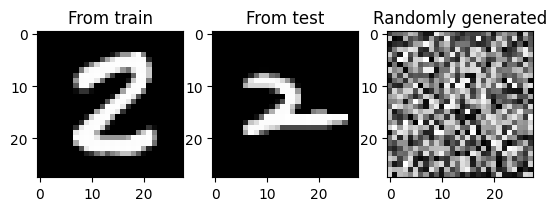

In [ ]:

##############################set params############################
perturbation_factor =0.1
num_sampling = 10000
test_num = 10
####################################################################

# temp_train_idx = 245
# temp_test_idx = 76
temp_train_idx = random.randint(0, len(train_target)-1)
temp_test_idx = random.randint(0, len(test_target)-1)

temp_train_img = train_data[temp_train_idx]
temp_test_img = test_data[temp_test_idx]
temp_gen_img = torch.rand(1, 28, 28)

plt.style.use('default')
f, axarr = plt.subplots(1, 3)
axarr[0].imshow(temp_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
axarr[0].title.set_text('From train')
axarr[1].imshow(temp_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
axarr[1].title.set_text('From test')
axarr[2].imshow(temp_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
axarr[2].title.set_text('Randomly generated')
# plt.title(f"Train, test, random generate")
plt.show()
plt.close(f)

temp_extended_train = temp_train_img.repeat(num_sampling, 1, 1, 1).to(device)
temp_extended_test = temp_test_img.repeat(num_sampling, 1, 1, 1).to(device)
temp_extended_gen = temp_gen_img.repeat(num_sampling, 1, 1, 1).to(device)

temp_train_noise = torch.normal(0, 1, size=extended_train.shape) * perturbation_factor
temp_test_noise = torch.normal(0, 1, size=extended_test.shape) * perturbation_factor
temp_gen_noise = torch.normal(0, 1, size=extended_gen.shape) * perturbation_factor

temp_extended_train = temp_extended_train + temp_train_noise.to(device)
temp_extended_test = temp_extended_test + temp_test_noise.to(device)
temp_extended_gen = temp_extended_gen + temp_gen_noise.to(device)


# try on different untrained models
for _ in range(test_num):
    temp_untrained_model = FeedforwardNeuralNetModel(28 * 28, 128, 10).to(device)

    with torch.no_grad():
        train_outputs = temp_untrained_model(temp_extended_train).argmax(dim=1)
        test_outputs = temp_untrained_model(temp_extended_test).argmax(dim=1)
        gen_outputs = temp_untrained_model(temp_extended_gen).argmax(dim=1)

    draw_distribution(train_outputs, test_outputs, gen_outputs,
                      f"Prediction distribution for untrained model with same {num_sampling} samples with perurbation factor {perturbation_factor}")

#### same trained model, neighborhood of different randomly generated images
to see if the distributions are similar on the neighborhood of different randomly generated images

In [ ]:
# Try several different random image and see the distribution of their neighborhood.
# This is to see the distribution if it is similar distribution
test_num = 10
test_sample_num = 10000
test_p_factor = 3
for _ in range(test_num):

    one_rand_img = torch.rand(1, 28, 28)
    extend_one_rand_img =  random_gen_img.repeat(test_sample_num,1,1,1)
    
    img_noise = torch.normal(0, 1, size=extend_one_rand_img.shape) * test_p_factor
    
    extend_one_rand_img = extend_one_rand_img + img_noise
    with torch.no_grad():
        try_outputs = model(extend_one_rand_img.to(device)).argmax(dim=1)
    plt.style.use('seaborn')
    f = plt.figure()
    try_df = pd.DataFrame(try_outputs.cpu().numpy(), columns = ['try'])
    sns.countplot(data=try_df, x="try", order=list(range(10)))




#### check the predictions of different randomly images by the same trained model
- Note: not the beighborhood of the images, because we observed before that one model tends to give the same prediction to any randomly generated images.

In [ ]:
#trained model with different randomly generated images

last = None
num_sample = 100
t = torch.randint(0, 100, (num_sample,1))
t = t.repeat(1,28*28)
t = t.reshape(num_sample,1,28,28).to(device)


rimgs_org = torch.rand(num_sample, 1, 28, 28).to(device)
rimgs = (rimgs_org*t).to(device)


with torch.no_grad():
    org_outputs = model(rimgs_org)
    after_outputs = model(rimgs)
print("Logits of the orginal randomly generated image\n", org_outputs)
print("Logits of appying a scalar to the randomly generated image\n", after_outputs)
org_df = pd.DataFrame(org_outputs.argmax(dim=1).cpu().numpy(), columns = ['org_prediction'])
after_df = pd.DataFrame(after_outputs.argmax(dim=1).cpu().numpy(), columns = ['after_prediction'])

plt.style.use('seaborn')
f, axarr = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout(pad=3) 
sns.countplot(data=org_df, x="org_prediction", order=list(range(10)), ax=axarr[0])
sns.countplot(data=after_df, x="after_prediction", order=list(range(10)), ax=axarr[1])
# plt.suptitle(title)
plt.suptitle(f"trained model with {num_sample} different randomly generated images")
plt.show()
plt.close(f)


#### same untrained model, neighborhood of different randomly generated images

In [ ]:
#new untrained model with different randomly generated images


new_untrained = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
num_sample = 100
t = torch.randint(0, 100, (num_sample,1))
t = t.repeat(1,28*28)
t = t.reshape(num_sample,1,28,28).to(device)


rimgs_org = torch.rand(num_sample, 1, 28, 28).to(device)
rimgs = (rimgs_org*t).to(device)


with torch.no_grad():
    org_outputs = new_untrained(rimgs_org)
    after_outputs = new_untrained(rimgs)

print("Logits of the orginal randomly generated image\n", org_outputs)
print("Logits of appying a scalar to the randomly generated image\n", after_outputs)
org_df = pd.DataFrame(org_outputs.argmax(dim=1).cpu().numpy(), columns = ['org_prediction'])
after_df = pd.DataFrame(after_outputs.argmax(dim=1).cpu().numpy(), columns = ['after_prediction'])

plt.style.use('seaborn')
f, axarr = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout(pad=3) 
sns.countplot(data=org_df, x="org_prediction", order=list(range(10)), ax=axarr[0])
sns.countplot(data=after_df, x="after_prediction", order=list(range(10)), ax=axarr[1])
# plt.suptitle(title)
plt.suptitle(f"untrained model with {num_sample} different randomly generated images")
plt.show()
plt.close(f)


#### same neighborhood of train, test and randomly generated images, different untrained models

In [ ]:
# try same random image but different untrained models

num_sample = 10000


# try_train_idx = 245
# try_test_idx = 76
try_train_idx = random.randint(0, len(train_target)-1)
try_test_idx = random.randint(0, len(test_target)-1)

try_train_img = train_data[try_train_idx]
try_test_img = test_data[try_test_idx]
print(try_train_img.shape)


t = random.randint(0,100)
print(f"scalar: {t}")
rimg_org = torch.rand(1,1, 28, 28).to(device)
rimg = rimg_org*t


plt.style.use('default')
f, axarr = plt.subplots(1, 4)
axarr[0].imshow(try_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
axarr[0].title.set_text('From train')
axarr[1].imshow(try_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
axarr[1].title.set_text('From test')
axarr[2].imshow(rimg_org.cpu().detach().numpy().reshape(28, 28), cmap="gray")
axarr[2].title.set_text('Randomly generated')
axarr[3].imshow(rimg.cpu().detach().numpy().reshape(28, 28), cmap="gray")
axarr[3].title.set_text('Randomly generated * scalar')
# plt.title(f"Train, test, random generate")
plt.show()
plt.close(f)

train_outputs = []
test_outputs = []
org_outputs = []
after_outputs = []
for _ in range(num_sample):
    new_untrained = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
    
    with torch.no_grad():
        org_o = new_untrained(rimg_org).argmax(dim=1)
        after_o = new_untrained(rimg).argmax(dim=1)
        train_o = new_untrained(try_train_img[None, :]).argmax(dim=1)
        test_o = new_untrained(try_test_img[None, :]).argmax(dim=1)
        
    org_outputs.append(org_o.item())
    after_outputs.append(after_o.item())
    train_outputs.append(train_o.item())
    test_outputs.append(test_o.item())
#         print(o, "\n", o.argmax(dim=1).item())
#     last = rimg
try_train_df = pd.DataFrame(train_outputs, columns = ['train_prediction'])
try_test_df = pd.DataFrame(test_outputs, columns = ['test_prediction'])
org_df = pd.DataFrame(org_outputs, columns = ['org_prediction'])
after_df = pd.DataFrame(after_outputs, columns = ['after_prediction'])

plt.style.use('seaborn')
f, axarr = plt.subplots(1, 4, figsize=(15, 5))
# f.tight_layout(pad=4) 
sns.countplot(data=try_train_df, x="train_prediction", order=list(range(10)), ax=axarr[0])
sns.countplot(data=try_test_df, x="test_prediction", order=list(range(10)), ax=axarr[1])
sns.countplot(data=org_df, x="org_prediction", order=list(range(10)), ax=axarr[2])
sns.countplot(data=after_df, x="after_prediction", order=list(range(10)), ax=axarr[3])
# plt.suptitle(title)
axarr[0].set_title("train_img")
axarr[1].set_title("test_img")
axarr[2].set_title("random_img")
axarr[3].set_title(f"t*random_img(t={t})")
plt.suptitle(f" {num_sample} different untrained models with same randomly generated image")
plt.show()
plt.close(f)

### Check setting bias=0 for untrained model

In [ ]:

bias_untrained_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
print(LOADPATH)
bias_untrained_model.load_state_dict(torch.load(LOADPATH))
bias_untrained_model_before= copy.deepcopy(bias_untrained_model)

bias_untrained_model.fc1.bias =torch.nn.Parameter( torch.zeros(size = bias_untrained_model.fc1.bias.shape).to(device)  )

bias_untrained_model.fc2.bias =torch.nn.Parameter( torch.zeros(size = bias_untrained_model.fc2.bias.shape).to(device)  )
bias_untrained_model.fc3.bias =torch.nn.Parameter( torch.zeros(size = bias_untrained_model.fc3.bias.shape).to(device)  )
bias_untrained_model.fc4.bias =torch.nn.Parameter( torch.zeros(size = bias_untrained_model.fc4.bias.shape).to(device)  )



##############################set params############################
perturbation_factor = 0.1
num_sampling = 100000
####################################################################


for picked_cls in range(10):
    train_cls_idx = train_target==picked_cls    

    sub_train_dataset = train_data[train_cls_idx].to(device)
    sub_train_targets = train_target[train_cls_idx].to(device)

    test_cls_idx = test_target==picked_cls

    sub_test_dataset = test_data[test_cls_idx].to(device)
    sub_test_targets = test_target[test_cls_idx].to(device)


    random_train_idx = random.randint(0, len(sub_train_targets)-1)
    random_test_idx = random.randint(0, len(sub_test_targets)-1)


    random_train_img = sub_train_dataset[random_train_idx]
    random_test_img = sub_test_dataset[random_test_idx]
    random_gen_img = torch.rand(1, 28, 28)

    plt.style.use('default')
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(random_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0].title.set_text('From train')
    axarr[1].imshow(random_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1].title.set_text('From test')
    axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[2].title.set_text('Randomly generated')
    # plt.title(f"Train, test, random generate")
    plt.show()
    plt.close(f)


    

    extended_train = random_train_img.repeat(num_sampling,1,1,1).to(device)
    extended_test = random_test_img.repeat(num_sampling,1,1,1).to(device)
    extended_gen = random_gen_img.repeat(num_sampling,1,1,1).to(device)

    
    train_noise = torch.normal(0, 1, size=extended_train.shape) * perturbation_factor
    test_noise = torch.normal(0, 1, size=extended_test.shape) * perturbation_factor
    gen_noise = torch.normal(0, 1, size=extended_gen.shape) * perturbation_factor

    extended_train = extended_train + train_noise.to(device)
    extended_test = extended_test + test_noise.to(device)
    extended_gen = gen_noise.to(device)


    # print("untrained:")
    with torch.no_grad():
        train_outputs = bias_untrained_model_before(extended_train).argmax(dim=1)
        test_outputs = bias_untrained_model_before(extended_test).argmax(dim=1)
        gen_outputs = bias_untrained_model_before(extended_gen).argmax(dim=1)
        
        train_outputs_zero_bias = bias_untrained_model(extended_train).argmax(dim=1)
        test_outputs_zero_bias = bias_untrained_model(extended_test).argmax(dim=1)
        gen_outputs_zero_bias = bias_untrained_model(extended_gen).argmax(dim=1)
    draw_distribution(train_outputs, test_outputs, gen_outputs, f"Original bias: Prediction distribution for untrained model with {num_sampling} samples with perurbation factor {perturbation_factor}")
    draw_distribution(train_outputs_zero_bias, test_outputs_zero_bias, gen_outputs_zero_bias, f"Setting bias=0: Prediction distribution for untrained model with {num_sampling} samples with perurbation factor {perturbation_factor}")




## Draw distributions for attacked images
- Here has a thing we need to notice: for the attack, it asks for the model when doing the attack, so for this one, when we draw the distribution for each model, we need to get new set of images. (The old strategy is get a set of images and then draw the distribution of the neighborhood with all the models, i.e. the half-trained and trained  models)

### Check fgm method


In [ ]:

############################Set params###########################
# series_model_name = "FFN19-44-07"
series_model_name = "FFN15-58-32"
model_ep = [0,5,10,15,20,25]
# model_ep = [25]


perturbation_factor = 0.1
num_sampling = 100000

atk_choice = "fgm"
#################################################################




for ep in model_ep:
    new_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
    new_model.load_state_dict(torch.load(series_model_name +f"-ep{ep}"))
    
    # get all the images attacked successfully
    after_atk_train = successfully_attack_samples_for_each_cls(train_data, train_target, new_model, atks[atk_choice]["method"], atks[atk_choice]["args"])
    after_atk_test = successfully_attack_samples_for_each_cls(test_data, test_target, new_model, atks[atk_choice]["method"], atks[atk_choice]["args"])

    samples = {}


    for picked_cls in range(10):
        
        # only keep the images from the one class
        train_cls_idx = after_atk_train["after_atk_target_org"]==picked_cls    

        sub_atk_train_dataset = after_atk_train["after_atk_data"][train_cls_idx]
        sub_atk_train_targets = after_atk_train["after_atk_target"][train_cls_idx]
        sub_atk_train_dataset_org = after_atk_train["after_atk_data_org"][train_cls_idx]
        sub_atk_train_targets_org = after_atk_train["after_atk_target_org"][train_cls_idx]

        test_cls_idx = after_atk_test["after_atk_target_org"]==picked_cls

        sub_atk_test_dataset = after_atk_test["after_atk_data"][test_cls_idx]
        sub_atk_test_targets = after_atk_test["after_atk_target"][test_cls_idx]
        sub_atk_test_dataset_org = after_atk_test["after_atk_data_org"][test_cls_idx]
        sub_atk_test_targets_org = after_atk_test["after_atk_target_org"][test_cls_idx]

        random_atk_train_idx = random.randint(0, len(sub_atk_train_targets)-1)
        random_atk_test_idx = random.randint(0, len(sub_atk_test_targets)-1)

        
        random_atk_train_img = sub_atk_train_dataset[random_atk_train_idx]
        random_atk_train_org_img = sub_atk_train_dataset_org[random_atk_train_idx]

        random_atk_test_img = sub_atk_test_dataset[random_atk_test_idx]
        random_atk_test_org_img = sub_atk_test_dataset_org[random_atk_test_idx]

        random_atk_train_label = sub_atk_train_targets[random_atk_train_idx]
        random_atk_train_org_label = sub_atk_train_targets_org[random_atk_train_idx]
        
        random_atk_test_label = sub_atk_test_targets[random_atk_test_idx]
        random_atk_test_org_label = sub_atk_test_targets_org[random_atk_test_idx]
        
        attack_method = atks[atk_choice]["method"]
        random_gen_img = torch.rand(1, 28, 28)
        random_atk_gen_img = attack_method(model_fn= new_model, x= random_gen_img[None, :], **atks[atk_choice]["args"])[0]
        
        
        with torch.no_grad():
            o = new_model((random_atk_train_img[None, :]).to(device)).argmax(dim=1).item()
            assert o == random_atk_train_label
            o1 = new_model((random_atk_test_img[None, :]).to(device)).argmax(dim=1).item()
            assert o1 == random_atk_test_label
            random_gen_label = new_model((random_gen_img[None, :]).to(device)).argmax(dim=1).item()
            random_atk_gen_label= new_model((random_atk_gen_img[None, :]).to(device)).argmax(dim=1).item()
        
        
        plt.style.use('default')
        f, axarr = plt.subplots(2, 3)
        axarr[0][0].imshow(random_atk_train_org_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
        axarr[0][0].set_title(f'Train - GT: {random_atk_train_org_label}', fontsize=10)
        axarr[0][1].imshow(random_atk_test_org_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
        axarr[0][1].set_title(f'Test - GT: {random_atk_test_org_label}', fontsize=10)
        axarr[0][2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
        axarr[0][2].set_title(f'Random - pred {random_gen_label}', fontsize=10)
        
        axarr[1][0].imshow(random_atk_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
        axarr[1][0].set_title(f'{atk_choice} Train - pred: {random_atk_train_label}', fontsize=10)
        axarr[1][1].imshow(random_atk_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
        axarr[1][1].set_title(f'{atk_choice} Test - pred: {random_atk_test_label}', fontsize=10)
        axarr[1][2].imshow(random_atk_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
        axarr[1][2].set_title(f'{atk_choice} Random - pred {random_atk_gen_label}', fontsize=10)
    #     axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    #     axarr[2].title.set_text('Randomly generated')
        # plt.title(f"Train, test, random generate")
        plt.show()
        plt.close(f)
        

        # find the neighborhood for these images
        extended_train = random_atk_train_org_img.repeat(num_sampling,1,1,1)
        extended_test = random_atk_test_org_img.repeat(num_sampling,1,1,1)
        extended_gen = random_gen_img.repeat(num_sampling,1,1,1)
        extended_train_atk = random_atk_train_img.repeat(num_sampling,1,1,1)
        extended_test_atk= random_atk_test_img.repeat(num_sampling,1,1,1)
        extended_gen_atk = random_atk_gen_img.repeat(num_sampling,1,1,1)
        

        train_noise = torch.normal(0, 1, size=extended_train.shape) * perturbation_factor
        test_noise = torch.normal(0, 1, size=extended_test.shape) * perturbation_factor
        gen_noise = torch.normal(0, 1, size=extended_gen.shape) * perturbation_factor
        
        atk_train_noise = torch.normal(0, 1, size=extended_train_atk.shape) * perturbation_factor
        atk_test_noise = torch.normal(0, 1, size=extended_test_atk.shape) * perturbation_factor
        atk_gen_noise = torch.normal(0, 1, size=extended_gen_atk.shape) * perturbation_factor

        extended_train = extended_train + train_noise
        extended_test = extended_test + test_noise
        extended_gen = extended_gen + gen_noise
        extended_train_atk = extended_train_atk + atk_train_noise
        extended_test_atk = extended_test_atk + atk_test_noise
        extended_gen_atk = extended_gen_atk + atk_gen_noise
        
        
        # save the neighborhoods
        samples[picked_cls] = (extended_train, extended_test, extended_gen, 
                               extended_train_atk, extended_test_atk, extended_gen_atk, 
                               random_atk_train_label, random_atk_test_label, random_gen_label, random_atk_gen_label)
    
    
    plt.style.use('seaborn')
    f, axarr = plt.subplots(10, 6,  figsize=(15, 40))
    f.tight_layout(pad=4)
    f.subplots_adjust(top=0.96)
    plt.suptitle(f"distributions for all the classes with atk {atk_choice} - Noise factor {perturbation_factor}",fontsize=20)
    for cls in samples:
        (extended_train, extended_test, extended_gen, 
                               extended_train_atk, extended_test_atk, extended_gen_atk, 
                               random_atk_train_label, random_atk_test_label, random_gen_label, random_atk_gen_label) = samples[cls]
        with torch.no_grad():
            train_outputs = new_model(extended_train.to(device)).argmax(dim=1)
            test_outputs = new_model(extended_test.to(device)).argmax(dim=1)
            gen_outputs = new_model(extended_gen.to(device)).argmax(dim=1)
            atk_train_outputs = new_model(extended_train_atk.to(device)).argmax(dim=1)
            atk_test_outputs = new_model(extended_test_atk.to(device)).argmax(dim=1)
            atk_gen_outputs = new_model(extended_gen_atk.to(device)).argmax(dim=1)

        train_df = pd.DataFrame(train_outputs.cpu().numpy(), columns = ['train_prediction'])
        test_df = pd.DataFrame(test_outputs.cpu().numpy(), columns = ['test_prediction'])
        gen_df = pd.DataFrame(gen_outputs.cpu().numpy(), columns = ['gen_prediction'])
        atk_train_df = pd.DataFrame(atk_train_outputs.cpu().numpy(), columns = ['atk_train_prediction'])
        atk_test_df = pd.DataFrame(atk_test_outputs.cpu().numpy(), columns = ['atk_test_prediction'])
        atk_gen_df = pd.DataFrame(atk_gen_outputs.cpu().numpy(), columns = ['atk_gen_prediction'])
        
        sns.countplot(data=train_df, x="train_prediction", order=list(range(10)), ax=axarr[cls][0])
        sns.countplot(data=atk_train_df, x="atk_train_prediction", order=list(range(10)), ax=axarr[cls][1])

        sns.countplot(data=test_df, x="test_prediction", order=list(range(10)), ax=axarr[cls][2])
        sns.countplot(data=atk_test_df, x="atk_test_prediction", order=list(range(10)), ax=axarr[cls][3])

        sns.countplot(data=gen_df, x="gen_prediction", order=list(range(10)), ax=axarr[cls][4])
        sns.countplot(data=atk_gen_df, x="atk_gen_prediction", order=list(range(10)), ax=axarr[cls][5])
        
        axarr[cls][0].set_title(f'train nbhd - ep {ep} - class {cls}')
        axarr[cls][1].set_title(f'atk train nbhd - ep {ep} - pred: {random_atk_train_label}')

        axarr[cls][2].set_title(f'test nbhd - ep {ep} - class {cls}')
        axarr[cls][3].set_title(f'atk test nbhd - ep {ep} - pred: {random_atk_test_label}')

        axarr[cls][4].set_title(f'gen nbhd - ep {ep} - pred: {random_gen_label}')
        axarr[cls][5].set_title(f'atk gen nbhd - ep {ep} - pred : {random_atk_gen_label}')
        
#         axarr[cls][2].set_title(f'Around random image from class {cls} at ep {ep}')
    plt.show()
    plt.close(f)



In [ ]:
##############################set params############################
# series_model_name = "FFN19-44-07"
series_model_name = "FFN15-58-32"
model_ep = [0,5,10,15,20,25]


perturbation_factor = 0.1
num_sampling = 100000

atk_choice = "fgm"
####################################################################




for ep in model_ep:
    new_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
    new_model.load_state_dict(torch.load(series_model_name +f"-ep{ep}"))

    after_atk_train = successfully_attack_samples_for_each_cls(train_data, train_target, new_model, atks[atk_choice]["method"], atks[atk_choice]["args"])
    after_atk_test = successfully_attack_samples_for_each_cls(test_data, test_target, new_model, atks[atk_choice]["method"], atks[atk_choice]["args"])

    samples = {}


    for picked_cls in range(10):
        train_cls_idx = after_atk_train["after_atk_target_org"]==picked_cls    

        sub_atk_train_dataset = after_atk_train["after_atk_data"][train_cls_idx]
        sub_atk_train_targets = after_atk_train["after_atk_target"][train_cls_idx]

        test_cls_idx = after_atk_test["after_atk_target_org"]==picked_cls

        sub_atk_test_dataset = after_atk_test["after_atk_data"][test_cls_idx]
        sub_atk_test_targets = after_atk_test["after_atk_target"][test_cls_idx]

        random_atk_train_idx = random.randint(0, len(sub_atk_train_targets)-1)
        random_atk_test_idx = random.randint(0, len(sub_atk_test_targets)-1)

        random_atk_train_img = sub_atk_train_dataset[random_atk_train_idx]
        random_atk_test_img = sub_atk_test_dataset[random_atk_test_idx]

        random_atk_train_label = sub_atk_train_targets[random_atk_train_idx]
        random_atk_test_label = sub_atk_test_targets[random_atk_test_idx]
        
        
        plt.style.use('default')
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(random_atk_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
        axarr[0].title.set_text(f'Train - after atk pred: {random_atk_train_label}')
        axarr[1].imshow(random_atk_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
        axarr[1].title.set_text(f'Test - after atk pred: {random_atk_test_label}')
    #     axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    #     axarr[2].title.set_text('Randomly generated')
        # plt.title(f"Train, test, random generate")
        plt.show()
        plt.close(f)
        
        with torch.no_grad():
            o = new_model((random_atk_train_img[None, :]).to(device)).argmax(dim=1).item()
            assert o == random_atk_train_label
            o1 = new_model((random_atk_test_img[None, :]).to(device)).argmax(dim=1).item()
            assert o1 == random_atk_test_label

        extended_train = random_atk_train_img.repeat(num_sampling,1,1,1)
        extended_test = random_atk_test_img.repeat(num_sampling,1,1,1)
    #     extended_gen = random_gen_img.repeat(num_sampling,1,1,1)


        train_noise = torch.normal(0, 1, size=extended_train.shape) * perturbation_factor
        test_noise = torch.normal(0, 1, size=extended_test.shape) * perturbation_factor
    #     gen_noise = torch.normal(0, 1, size=extended_gen.shape) * perturbation_factor

        extended_train = extended_train + train_noise
        extended_test = extended_test + test_noise
    #     extended_gen = extended_gen + gen_noise

        samples[picked_cls] = (extended_train, extended_test, random_atk_train_label, random_atk_test_label)
    
    
    plt.style.use('seaborn')
    f, axarr = plt.subplots(10, 2,  figsize=(15, 40))
    f.tight_layout(pad=4)
    f.subplots_adjust(top=0.96)
    plt.suptitle(f"distributions for all the classes with atk {atk_choice} - Noise factor {perturbation_factor}",fontsize=20)
    for cls in samples:
        with torch.no_grad():
            train_outputs = new_model(samples[cls][0].to(device)).argmax(dim=1)
#             print(train_outputs)
            test_outputs = new_model(samples[cls][1].to(device)).argmax(dim=1)
#             gen_outputs = new_model(samples[cls][2].to(device)).argmax(dim=1)
#         train_df[cls] = train_outputs.cpu().numpy().copy()
#         test_df[cls] = test_outputs.cpu().numpy().copy()
#         gen_df[cls] = gen_outputs.cpu().numpy().copy()
#     print(train_df)
        train_df = pd.DataFrame(train_outputs.cpu().numpy(), columns = ['train_prediction'])
        test_df = pd.DataFrame(test_outputs.cpu().numpy(), columns = ['test_prediction'])
#         gen_df = pd.DataFrame(gen_outputs.cpu().numpy(), columns = ['gen_prediction'])
        sns.countplot(data=train_df, x="train_prediction", order=list(range(10)), ax=axarr[cls][0])
        sns.countplot(data=test_df, x="test_prediction", order=list(range(10)), ax=axarr[cls][1])
#         sns.countplot(data=gen_df, x="gen_prediction", order=list(range(10)), ax=axarr[cls][2])
        axarr[cls][0].set_title(f'Around train image from class {cls} at ep {ep} - pred of img: {samples[cls][2]}')
        axarr[cls][1].set_title(f'Around test image from class {cls} at ep {ep} - pred of img: {samples[cls][3]}')
#         axarr[cls][2].set_title(f'Around random image from class {cls} at ep {ep}')
    plt.show()
    plt.close(f)



# Compute Norm Adversial vs. Sample + noise



In [ ]:
def draw_norm_chart(org_train_img, atk_train_img, ns_train_img, train_noise, org_test_img, atk_test_img, ns_test_img, test_noise):
    diff_ns_atk_train = ( ns_train_img - atk_train_img).reshape(1,28*28)
    diff_org_atk_train = ( org_train_img - atk_train_img).reshape(1,28*28)
    diff_ns_atkns_train =( train_noise - (atk_train_img - org_train_img)).reshape(1,28*28)
    atkns_train = (atk_train_img - org_train_img).reshape(1,28*28)
    
    diff_ns_atk_test = ( ns_test_img - atk_test_img ).reshape(1,28*28)
    diff_org_atk_test = ( org_test_img - atk_test_img ).reshape(1,28*28)
    diff_ns_atkns_test =( test_noise - (atk_test_img - org_test_img)).reshape(1,28*28)
    atkns_test = (atk_test_img - org_test_img).reshape(1,28*28)
    
    divider = ' --------------------------------{}-------------------------------'
    row = "| {0:20} | {1:12.3f} | {2:12.3f} | {3:12.3f} |"
    
    print()
    print("==============================Vector Norm=============================")
    print("| {0:>20} | {1:>12} | {2:>12} | {3:>12} |".format(" ","L1", "L2", "L_inf"))
    print(divider.format("train"))
    print(row.format("X", torch.linalg.vector_norm(org_train_img, ord=1 ), 
                     torch.linalg.vector_norm(org_train_img, ord=2 ),
                    torch.linalg.vector_norm(org_train_img, ord=np.inf )))
    print(row.format("X_atk", torch.linalg.vector_norm(atk_train_img, ord=1 ), 
                     torch.linalg.vector_norm(atk_train_img, ord=2 ),
                    torch.linalg.vector_norm(atk_train_img, ord=np.inf )))
    print(row.format("NS", torch.linalg.vector_norm(train_noise, ord=1 ), 
                     torch.linalg.vector_norm(train_noise, ord=2 ),
                    torch.linalg.vector_norm(train_noise, ord=np.inf )))
    print(row.format("atk_NS", torch.linalg.vector_norm(atkns_train, ord=1 ), 
                     torch.linalg.vector_norm(atkns_train, ord=2 ),
                    torch.linalg.vector_norm(atkns_train, ord=np.inf )))
    print(row.format("X + NS", torch.linalg.vector_norm(ns_train_img, ord=1 ), 
                    torch.linalg.vector_norm(ns_train_img, ord=2 ),
                    torch.linalg.vector_norm(ns_train_img, ord=np.inf )))
    print(row.format("NS - atk_NS", torch.linalg.vector_norm(diff_ns_atk_train, ord=1 ), 
                     torch.linalg.vector_norm(diff_ns_atk_train, ord=2 ),
                    torch.linalg.vector_norm(diff_ns_atk_train, ord=np.inf )))
    print(row.format("X - X_atk", torch.linalg.vector_norm(diff_org_atk_train, ord=1 ), 
                     torch.linalg.vector_norm(diff_org_atk_train, ord=2 ),
                    torch.linalg.vector_norm(diff_org_atk_train, ord=np.inf )))
    print(row.format("X + NS - X_atk", torch.linalg.vector_norm(diff_ns_atk_train, ord=1 ), 
                     torch.linalg.vector_norm(diff_ns_atk_train, ord=2 ),
                    torch.linalg.vector_norm(diff_ns_atk_train, ord=np.inf )))
    print(divider.format("test-"))
    print(row.format("X", torch.linalg.vector_norm(org_test_img, ord=1 ), 
                     torch.linalg.vector_norm(org_test_img, ord=2 ),
                    torch.linalg.vector_norm(org_test_img, ord=np.inf )))
    print(row.format("X_atk", torch.linalg.vector_norm(atk_test_img, ord=1 ), 
                     torch.linalg.vector_norm(atk_test_img, ord=2 ),
                    torch.linalg.vector_norm(atk_test_img, ord=np.inf )))
    print(row.format("NS", torch.linalg.vector_norm(test_noise, ord=1 ), 
                     torch.linalg.vector_norm(test_noise, ord=2 ),
                    torch.linalg.vector_norm(test_noise, ord=np.inf )))
    print(row.format("atk_NS", torch.linalg.vector_norm(atkns_test, ord=1 ), 
                     torch.linalg.vector_norm(atkns_test, ord=2 ),
                    torch.linalg.vector_norm(atkns_test, ord=np.inf )))
    print(row.format("X + NS", torch.linalg.vector_norm(ns_test_img, ord=1 ), 
                    torch.linalg.vector_norm(ns_test_img, ord=2 ),
                    torch.linalg.vector_norm(ns_test_img, ord=np.inf )))
    print(row.format("NS - atk_NS", torch.linalg.vector_norm(diff_ns_atk_test, ord=1 ), 
                     torch.linalg.vector_norm(diff_ns_atk_test, ord=2 ),
                    torch.linalg.vector_norm(diff_ns_atk_test, ord=np.inf )))
    print(row.format("X - X_atk", torch.linalg.vector_norm(diff_org_atk_test, ord=1 ), 
                     torch.linalg.vector_norm(diff_org_atk_test, ord=2 ),
                    torch.linalg.vector_norm(diff_org_atk_test, ord=np.inf )))
    print(row.format("X + NS - X_atk", torch.linalg.vector_norm(diff_ns_atk_test, ord=1 ), 
                     torch.linalg.vector_norm(diff_ns_atk_test, ord=2 ),
                    torch.linalg.vector_norm(diff_ns_atk_test, ord=np.inf )))
    print(divider.format("-----"))
    
    
    
    diff_ns_atk_train = ( ns_train_img - atk_train_img).reshape(28,28)
    diff_org_atk_train = ( org_train_img - atk_train_img).reshape(28,28)
    diff_ns_atkns_train =( train_noise - (atk_train_img - org_train_img)).reshape(28,28)
    atkns_train = (atk_train_img - org_train_img).reshape(28,28)
    
    diff_ns_atk_test = ( ns_test_img - atk_test_img ).reshape(28,28)
    diff_org_atk_test = ( org_test_img - atk_test_img ).reshape(28,28)
    diff_ns_atkns_test =( test_noise - (atk_test_img - org_test_img)).reshape(28,28)
    atkns_test = (atk_test_img - org_test_img).reshape(28,28)
    
    print()
    print("==============================Matrix Norm=============================")
    print("| {0:>20} | {1:>12} | {2:>12} | {3:>12} |".format(" ","L1", "L2", "L_inf"))
    print(divider.format("train"))
    print(row.format("X", torch.linalg.matrix_norm(org_train_img.reshape(28,28), ord=1 ), 
                     torch.linalg.matrix_norm(org_train_img.reshape(28,28), ord=2 ),
                    torch.linalg.matrix_norm(org_train_img.reshape(28,28), ord=np.inf )))
    print(row.format("X_atk", torch.linalg.matrix_norm(atk_train_img.reshape(28,28), ord=1 ), 
                     torch.linalg.matrix_norm(atk_train_img.reshape(28,28), ord=2 ),
                    torch.linalg.matrix_norm(atk_train_img.reshape(28,28), ord=np.inf )))
    print(row.format("NS", torch.linalg.matrix_norm(train_noise.reshape(28,28), ord=1 ), 
                     torch.linalg.matrix_norm(train_noise.reshape(28,28), ord=2 ),
                    torch.linalg.matrix_norm(train_noise.reshape(28,28), ord=np.inf )))
    print(row.format("atk_NS", torch.linalg.matrix_norm(atkns_train, ord=1 ), 
                     torch.linalg.matrix_norm(atkns_train, ord=2 ),
                    torch.linalg.matrix_norm(atkns_train, ord=np.inf )))
    print(row.format("X + NS", torch.linalg.matrix_norm(ns_train_img.reshape(28,28), ord=1 ), 
                    torch.linalg.matrix_norm(ns_train_img.reshape(28,28), ord=2 ),
                    torch.linalg.matrix_norm(ns_train_img.reshape(28,28), ord=np.inf )))
    print(row.format("NS - atk_NS", torch.linalg.matrix_norm(diff_ns_atk_train, ord=1 ), 
                     torch.linalg.matrix_norm(diff_ns_atk_train, ord=2 ),
                    torch.linalg.matrix_norm(diff_ns_atk_train, ord=np.inf )))
    print(row.format("X - X_atk", torch.linalg.matrix_norm(diff_org_atk_train, ord=1 ), 
                     torch.linalg.matrix_norm(diff_org_atk_train, ord=2 ),
                    torch.linalg.matrix_norm(diff_org_atk_train, ord=np.inf )))
    print(row.format("X + NS - X_atk", torch.linalg.matrix_norm(diff_ns_atk_train, ord=1 ), 
                     torch.linalg.matrix_norm(diff_ns_atk_train, ord=2 ),
                    torch.linalg.matrix_norm(diff_ns_atk_train, ord=np.inf )))
    print(divider.format("test-"))
    print(row.format("X", torch.linalg.matrix_norm(org_test_img.reshape(28,28), ord=1 ), 
                     torch.linalg.matrix_norm(org_test_img.reshape(28,28), ord=2 ),
                    torch.linalg.matrix_norm(org_test_img.reshape(28,28), ord=np.inf )))
    print(row.format("X_atk", torch.linalg.matrix_norm(atk_test_img.reshape(28,28), ord=1 ), 
                     torch.linalg.matrix_norm(atk_test_img.reshape(28,28), ord=2 ),
                    torch.linalg.matrix_norm(atk_test_img.reshape(28,28), ord=np.inf )))
    print(row.format("NS", torch.linalg.matrix_norm(test_noise.reshape(28,28), ord=1 ), 
                     torch.linalg.matrix_norm(test_noise.reshape(28,28), ord=2 ),
                    torch.linalg.matrix_norm(test_noise.reshape(28,28), ord=np.inf )))
    print(row.format("atk_NS", torch.linalg.matrix_norm(atkns_test, ord=1 ), 
                     torch.linalg.matrix_norm(atkns_test, ord=2 ),
                    torch.linalg.matrix_norm(atkns_test, ord=np.inf )))
    print(row.format("X + NS", torch.linalg.matrix_norm(ns_test_img.reshape(28,28), ord=1 ), 
                    torch.linalg.matrix_norm(ns_test_img.reshape(28,28), ord=2 ),
                    torch.linalg.matrix_norm(ns_test_img.reshape(28,28), ord=np.inf )))
    print(row.format("NS - atk_NS", torch.linalg.matrix_norm(diff_ns_atk_test, ord=1 ), 
                     torch.linalg.matrix_norm(diff_ns_atk_test, ord=2 ),
                    torch.linalg.matrix_norm(diff_ns_atk_test, ord=np.inf )))
    print(row.format("X - X_atk", torch.linalg.matrix_norm(diff_org_atk_test, ord=1 ), 
                     torch.linalg.matrix_norm(diff_org_atk_test, ord=2 ),
                    torch.linalg.matrix_norm(diff_org_atk_test, ord=np.inf )))
    print(row.format("X + NS - X_atk", torch.linalg.matrix_norm(diff_ns_atk_test, ord=1 ), 
                     torch.linalg.matrix_norm(diff_ns_atk_test, ord=2 ),
                    torch.linalg.matrix_norm(diff_ns_atk_test, ord=np.inf )))
    print(divider.format("-----"))

### Vector & Matrix norm L1, L2, L$\infty$

#### FGM

In [ ]:
##############################set params############################
# series_model_name = "FFN19-44-07"
series_model_name = "FFN15-58-32"
# model_ep = [25]
model_ep = [0,5,10,15,20,25]


perturbation_factor = 0.1


atk_choice = "fgm"
####################################################################


# random_train_pk_idx = random.randint(0, len(train_target )-1)
# random_test_pk_idx = random.randint(0, len(test_target )-1)

# picked_train_data = train_data[random_train_pk_idx:random_train_pk_idx+1]
# picked_train_target = train_target[random_train_pk_idx:random_train_pk_idx+1]

# picked_test_data = test_data[random_test_pk_idx:random_test_pk_idx+1]
# picked_test_target = test_target[random_test_pk_idx:random_test_pk_idx+1]

picked_train_data = train_data
picked_train_target = train_target

picked_test_data = test_data
picked_test_target = test_target

for ep in model_ep:
    new_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
    model_path =series_model_name +f"-ep{ep}"
    new_model.load_state_dict(torch.load(model_path))
    new_model.eval()
    
    print(f"============================================For model {model_path}============================================")

    after_atk_train = successfully_attack_samples_for_each_cls(picked_train_data, picked_train_target, new_model, atks[atk_choice]["method"], atks[atk_choice]["args"])
    after_atk_test = successfully_attack_samples_for_each_cls(picked_test_data, picked_test_target, new_model, atks[atk_choice]["method"], atks[atk_choice]["args"])
    
    
    random_train_idx = random.randint(0, len( after_atk_train["after_atk_target"])-1)
    random_test_idx = random.randint(0, len( after_atk_test["after_atk_target"])-1)
    
    atk_train_img = after_atk_train["after_atk_data"][random_train_idx]
    atk_test_img = after_atk_test["after_atk_data"][random_test_idx]
    atk_train_label = after_atk_train["after_atk_target"][random_train_idx]
    atk_test_label = after_atk_test["after_atk_target"][random_test_idx]
    
    org_train_img = after_atk_train["after_atk_data_org"][random_train_idx]
    org_test_img = after_atk_test["after_atk_data_org"][random_test_idx]
    org_train_label = after_atk_train["after_atk_target_org"][random_train_idx]
    org_test_label = after_atk_test["after_atk_target_org"][random_test_idx]
    
    
    train_noise = torch.normal(0, 1, size=org_train_img.shape) * perturbation_factor
    test_noise = torch.normal(0, 1, size=org_test_img.shape) * perturbation_factor
    
    ns_train_img = org_train_img + train_noise
    ns_test_img = org_test_img + test_noise
    
    
    with torch.no_grad():
        train_outputs = new_model(ns_train_img[None, :].to(device)).argmax(dim=1)
        test_outputs = new_model(ns_test_img[None, :].to(device)).argmax(dim=1)
        
    plt.style.use('default')
    f, axarr = plt.subplots(2, 3)
    axarr[0][0].imshow(org_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0][0].title.set_text(f'Org Train - GT {org_train_label}')
    axarr[0][1].imshow(atk_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0][1].title.set_text(f'Atk Train - pred: {atk_train_label}')
    axarr[0][2].imshow(ns_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0][2].title.set_text(f'Noise {perturbation_factor} Train - pred: {train_outputs.item()}')
    
    axarr[1][0].imshow(org_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1][0].title.set_text(f'Org Test -  GT {org_test_label}')
    axarr[1][1].imshow(atk_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1][1].title.set_text(f'Atk Test - pred: {atk_test_label}')
    axarr[1][2].imshow(ns_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1][2].title.set_text(f'Noise {perturbation_factor} Test - pred: {test_outputs.item()}')
#     axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
#     axarr[2].title.set_text('Randomly generated')
    # plt.title(f"Train, test, random generate")
    plt.show()
    plt.close(f)
    
    
    print(f"For original train image: min {torch.min(org_train_img)}, max {torch.max(org_train_img)}, mean {torch.mean(org_train_img)}.")
    print(f"For original test image: min {torch.min(org_test_img)}, max {torch.max(org_test_img)}, mean {torch.mean(org_test_img)}.")
    
    draw_norm_chart(org_train_img, atk_train_img, ns_train_img, train_noise, org_test_img, atk_test_img, ns_test_img, test_noise)

    
    


# Avg norm

### avg norm - fgm

In [ ]:

##############################set params############################
atk_choice = "fgm"
# series_model_name = "FFN19-44-07"
series_model_name = "FFN15-58-32"
# model_ep = [25]

model_ep = [0,5,10,15,20,25]
perturbation_factor = 0.1
print(f"FACTOR = {perturbation_factor}")
num_sampling = 100000
####################################################################


# random_train_pk_idx = random.randint(0, len(train_target )-1)
# random_test_pk_idx = random.randint(0, len(test_target )-1)

# picked_train_data = train_data[random_train_pk_idx:random_train_pk_idx+1]
# picked_train_target = train_target[random_train_pk_idx:random_train_pk_idx+1]

# picked_test_data = test_data[random_test_pk_idx:random_test_pk_idx+1]
# picked_test_target = test_target[random_test_pk_idx:random_test_pk_idx+1]

picked_train_data = train_data
picked_train_target = train_target

picked_test_data = test_data
picked_test_target = test_target

for ep in model_ep:
    new_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
    model_path =series_model_name +f"-ep{ep}"
    new_model.load_state_dict(torch.load(model_path))
    new_model.eval()
    
    print(f"============================================For model {model_path}============================================")

    after_atk_train = successfully_attack_samples_for_each_cls(picked_train_data, picked_train_target, new_model, atks[atk_choice]["method"], atks[atk_choice]["args"])
    after_atk_test = successfully_attack_samples_for_each_cls(picked_test_data, picked_test_target, new_model, atks[atk_choice]["method"], atks[atk_choice]["args"])
    
    random_train_idx =236
    random_test_idx = 25
    
#     random_train_idx = random.randint(0, len( after_atk_train["after_atk_target"])-1)
#     random_test_idx = random.randint(0, len( after_atk_test["after_atk_target"])-1)
 
    
    
    atk_train_img = after_atk_train["after_atk_data"][random_train_idx]
    atk_test_img = after_atk_test["after_atk_data"][random_test_idx]
    atk_train_label = after_atk_train["after_atk_target"][random_train_idx]
    atk_test_label = after_atk_test["after_atk_target"][random_test_idx]
    
    org_train_img = after_atk_train["after_atk_data_org"][random_train_idx]
    org_test_img = after_atk_test["after_atk_data_org"][random_test_idx]
#     org_test_img = org_train_img
    org_train_label = after_atk_train["after_atk_target_org"][random_train_idx]
    org_test_label = after_atk_test["after_atk_target_org"][random_test_idx]
    
    extend_org_train_img = org_train_img.repeat(num_sampling,1,1,1)
    extend_org_test_img = org_test_img.repeat(num_sampling,1,1,1)
    
    attack_method = atks[atk_choice]["method"]
    extend_atk_train_img = attack_method(model_fn= new_model, x= extend_org_train_img, **atks[atk_choice]["args"])
    extend_atk_test_img = attack_method(model_fn= new_model, x= extend_org_test_img, **atks[atk_choice]["args"])
    
    train_noise = torch.normal(0, 1, size=extend_org_train_img.shape) * perturbation_factor
    test_noise = torch.normal(0, 1, size=extend_org_test_img.shape) * perturbation_factor
    
    
    
#     ns_train_img = org_train_img + train_noise
#     ns_test_img = org_test_img + test_noise
    
    
#     with torch.no_grad():
#         train_outputs = new_model(ns_train_img[None, :].to(device)).argmax(dim=1)
#         test_outputs = new_model(ns_test_img[None, :].to(device)).argmax(dim=1)

    print(extend_org_train_img.shape)
        
    plt.style.use('default')
    f, axarr = plt.subplots(2, 2)
#     f.tight_layout(pad=2) 
    axarr[0][0].imshow(org_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0][0].title.set_text(f'Org Train - GT {org_train_label}')
    axarr[0][1].imshow(atk_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0][1].title.set_text(f'Atk Train - pred: {atk_train_label}')
#     axarr[0][2].imshow(ns_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
#     axarr[0][2].title.set_text(f'Noise {perturbation_factor} Train - pred: {train_outputs.item()}')
    
    axarr[1][0].imshow(org_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1][0].title.set_text(f'Org Test -  GT {org_test_label}')
    axarr[1][1].imshow(atk_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1][1].title.set_text(f'Atk Test - pred: {atk_test_label}')
#     axarr[1][2].imshow(ns_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
#     axarr[1][2].title.set_text(f'Noise {perturbation_factor} Test - pred: {test_outputs.item()}')
#     axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
#     axarr[2].title.set_text('Randomly generated')
    # plt.title(f"Train, test, random generate")
    plt.show()
    plt.close(f)
    
    atkns_train = (extend_atk_train_img - extend_org_train_img).reshape(-1, 28*28)
    atkns_test = (extend_atk_test_img - extend_org_test_img).reshape(-1, 28*28)
    
#     print(atkns_train == atkns_test)
    
    diff_ns_atk_train = (train_noise - (extend_atk_train_img - extend_org_train_img)).reshape(-1, 28*28)
    diff_ns_atk_test = (test_noise -  (extend_atk_test_img - extend_org_test_img)).reshape(-1, 28*28)
    
    divider = ' --------------------------------{}-------------------------------'
    row = "| {0:20} | {1:12.3f} | {2:12.3f} | {3:12.3f} |"
    
    print()
    print("==============================Vector Norm=============================")
    print("| {0:>20} | {1:>12} | {2:>12} | {3:>12} |".format(" ","L1", "L2", "L_inf"))
    print(divider.format("train"))
   
    print(row.format("NS", torch.linalg.vector_norm(train_noise.reshape(-1, 28*28), ord=1, dim=-1 ).mean(), 
                      torch.linalg.vector_norm(train_noise.reshape(-1, 28*28), ord=2, dim=-1 ).mean(),
                     torch.linalg.vector_norm(train_noise.reshape(-1, 28*28), ord=np.inf, dim=-1 ).mean()))
    
    print(row.format("atk_NS", torch.linalg.vector_norm(atkns_train, ord=1, dim=-1 ).mean(), 
                      torch.linalg.vector_norm(atkns_train, ord=2, dim=-1 ).mean(),
                     torch.linalg.vector_norm(atkns_train, ord=np.inf, dim=-1 ).mean()))
    
    print(row.format("NS - atk_NS", torch.linalg.vector_norm(diff_ns_atk_train, ord=1, dim=-1 ).mean(), 
                      torch.linalg.vector_norm(diff_ns_atk_train, ord=2, dim=-1 ).mean(),
                     torch.linalg.vector_norm(diff_ns_atk_train, ord=np.inf, dim=-1 ).mean()))
   

   
    print(divider.format("test-"))
    print(row.format("NS", torch.linalg.vector_norm(test_noise.reshape(-1, 28*28), ord=1, dim=-1 ).mean(), 
                      torch.linalg.vector_norm(test_noise.reshape(-1, 28*28), ord=2, dim=-1 ).mean(),
                     torch.linalg.vector_norm(test_noise.reshape(-1, 28*28), ord=np.inf, dim=-1 ).mean()))
    
    print(row.format("atk_NS", torch.linalg.vector_norm(atkns_test, ord=1, dim=-1 ).mean(), 
                      torch.linalg.vector_norm(atkns_test, ord=2, dim=-1 ).mean(),
                     torch.linalg.vector_norm(atkns_test, ord=np.inf, dim=-1 ).mean()))
    
    print(row.format("NS - atk_NS", torch.linalg.vector_norm(diff_ns_atk_test, ord=1, dim=-1 ).mean(), 
                      torch.linalg.vector_norm(diff_ns_atk_test, ord=2, dim=-1 ).mean(),
                     torch.linalg.vector_norm(diff_ns_atk_test, ord=np.inf, dim=-1 ).mean()))
    print(divider.format("-----"))
    
#     print(atkns_train.shape)
#     print(atkns_train - atkns_test)
#     print(torch.linalg.norm(atkns_train, ord=2, dim=-1 ))
#     print(torch.linalg.norm(atkns_test, ord=2, dim=-1 ))



    atkns_train = (extend_atk_train_img - extend_org_train_img).reshape(-1, 28,28)
    atkns_test = (extend_atk_test_img - extend_org_test_img).reshape(-1, 28,28)
    
    diff_ns_atk_train = (train_noise - (extend_atk_train_img - extend_org_train_img)).reshape(-1, 28,28)
    diff_ns_atk_test = (test_noise -  (extend_atk_test_img - extend_org_test_img)).reshape(-1, 28,28)
    
    
    print("==============================Matrix Norm=============================")
    print("| {0:>20} | {1:>12} | {2:>12} | {3:>12} |".format(" ","L1", "L2", "L_inf"))
    print(divider.format("train"))
   
    print(row.format("NS", torch.linalg.matrix_norm(train_noise.reshape(-1, 28,28), ord=1, dim=(-2, -1)).mean(), 
                      torch.linalg.matrix_norm(train_noise.reshape(-1, 28,28), ord=2, dim=(-2, -1) ).mean(),
                     torch.linalg.vector_norm(train_noise.reshape(-1, 28,28), ord=np.inf, dim=(-2, -1) ).mean()))
    
    print(row.format("atk_NS", torch.linalg.matrix_norm(atkns_train, ord=1, dim=(-2, -1) ).mean(), 
                      torch.linalg.matrix_norm(atkns_train, ord=2, dim=(-2, -1) ).mean(),
                     torch.linalg.matrix_norm(atkns_train, ord=np.inf, dim=(-2, -1) ).mean()))
    
    print(row.format("NS - atk_NS", torch.linalg.matrix_norm(diff_ns_atk_train, ord=1, dim=(-2, -1) ).mean(), 
                      torch.linalg.matrix_norm(diff_ns_atk_train, ord=2, dim=(-2, -1) ).mean(),
                     torch.linalg.matrix_norm(diff_ns_atk_train, ord=np.inf, dim=(-2, -1) ).mean()))

   
    print(divider.format("test-"))
    print(row.format("NS", torch.linalg.matrix_norm(test_noise.reshape(-1, 28,28), ord=1, dim=(-2, -1) ).mean(), 
                      torch.linalg.matrix_norm(test_noise.reshape(-1, 28,28), ord=2, dim=(-2, -1) ).mean(),
                     torch.linalg.matrix_norm(test_noise.reshape(-1, 28,28), ord=np.inf, dim=(-2, -1) ).mean()))
    
    print(row.format("atk_NS", torch.linalg.matrix_norm(atkns_test, ord=1, dim=(-2, -1) ).mean(), 
                      torch.linalg.matrix_norm(atkns_test, ord=2, dim=(-2, -1)).mean(),
                     torch.linalg.matrix_norm(atkns_test, ord=np.inf, dim=(-2, -1) ).mean()))
    
    print(row.format("NS - atk_NS", torch.linalg.matrix_norm(diff_ns_atk_test, ord=1, dim=(-2, -1)).mean(), 
                      torch.linalg.matrix_norm(diff_ns_atk_test, ord=2, dim=(-2, -1) ).mean(),
                     torch.linalg.matrix_norm(diff_ns_atk_test, ord=np.inf, dim=(-2, -1) ).mean()))
    print(divider.format("-----"))
    